In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import datetime
import time

%matplotlib inline

In [46]:
data = pd.read_csv("../dataset/T1.csv")
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [47]:
data.shape

(50530, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [6]:
data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [7]:
data.isnull().sum()


Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [8]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'],format="%d %m %Y %H:%M")


In [9]:
data['Year'] = data['Date/Time'].dt.year
data['Month'] = data['Date/Time'].dt.month
data['Day'] = data['Date/Time'].dt.day
data['Time_Hours'] = data['Date/Time'].dt.hour
data['Time_Minutes'] = data['Date/Time'].dt.minute

In [10]:
data.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Year', 'Month',
       'Day', 'Time_Hours', 'Time_Minutes'],
      dtype='object')

In [11]:
cols = [ 'Year', 'Month', "Day", "Time_Hours", "Time_Minutes" ]
data = data.drop(cols, axis=1)
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [12]:
df = data.copy()

# Building LSTM 

In [13]:



from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [14]:
# converting the Data/Time as the index for proper shape of the input.
df = df.set_index('Date/Time')

In [48]:
# Hardcode all variables
batch_size_exp = 1
epoch_exp = 15
neurons_exp = 10
predict_values_exp = 10000
lag_exp=24

In [16]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [17]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [18]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [19]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [20]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [21]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = tf.keras.models.Sequential()
    
    # Use LSTM layer with CuDNN backend if available
    if tf.test.is_gpu_available(cuda_only=True):
        model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    else:
        model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, implementation=2))
    
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    
    # Print model summary after training
    print(model.summary())
    
    return model

In [22]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [23]:
df.columns

Index(['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [24]:
'''Drop all the features as we will not be having any in production'''
del df['LV ActivePower (kW)']
del df['Theoretical_Power_Curve (KWh)']
del df['Wind Direction (°)']
df.head()

,Wind Speed (m/s)
Date/Time,
2018-01-01 00:00:00,5.311336
2018-01-01 00:10:00,5.672167
2018-01-01 00:20:00,5.216037
2018-01-01 00:30:00,5.659674
2018-01-01 00:40:00,5.577941


In [25]:
for i in range(0,10):
  df = df[:-1]
df.tail()

,Wind Speed (m/s)
Date/Time,
2018-12-31 21:30:00,8.472826
2018-12-31 21:40:00,8.433422
2018-12-31 21:50:00,9.976660
2018-12-31 22:00:00,10.416830
2018-12-31 22:10:00,10.713670


In [26]:
# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [27]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [53]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [55]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [56]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

40519/40519 [==============================] - 74s 2ms/step - loss: 0.0018
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 10)                   1400      
                                                                 
 dense_2 (Dense)             (1, 1)                    11        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [57]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 282ms/step
Hour=1, Predicted=4.164374, Expected=4.924129
1/1 [==============================] - 0s 16ms/step
Hour=2, Predicted=4.888399, Expected=4.177613
1/1 [==============================] - 0s 15ms/step
Hour=3, Predicted=4.146584, Expected=3.537138
1/1 [==============================] - 0s 14ms/step
Hour=4, Predicted=3.552464, Expected=3.451407
1/1 [==============================] - 0s 16ms/step
Hour=5, Predicted=3.401254, Expected=3.884698
1/1 [==============================] - 0s 18ms/step
Hour=6, Predicted=3.840448, Expected=5.382280
1/1 [==============================] - 0s 16ms/step
Hour=7, Predicted=5.403160, Expected=4.438734
1/1 [==============================] - 0s 17ms/step
Hour=8, Predicted=4.394953, Expected=2.460114
1/1 [==============================] - 0s 17ms/step
Hour=9, Predicted=2.496027, Expected=1.483567
1/1 [==============================] - 0s 15ms/step
Hour=10, Predicted=1.485544, Expected=3.122155
1/1 [=============

1/1 [==============================] - 0s 16ms/step
Hour=84, Predicted=2.553820, Expected=3.212906
1/1 [==============================] - 0s 16ms/step
Hour=85, Predicted=3.243375, Expected=3.382938
1/1 [==============================] - 0s 18ms/step
Hour=86, Predicted=3.413409, Expected=3.080471
1/1 [==============================] - 0s 16ms/step
Hour=87, Predicted=3.110950, Expected=2.453939
1/1 [==============================] - 0s 16ms/step
Hour=88, Predicted=2.484430, Expected=2.390433
1/1 [==============================] - 0s 15ms/step
Hour=89, Predicted=2.420935, Expected=2.967772
1/1 [==============================] - 0s 14ms/step
Hour=90, Predicted=2.998286, Expected=2.982195
1/1 [==============================] - 0s 15ms/step
Hour=91, Predicted=3.012723, Expected=3.276272
1/1 [==============================] - 0s 16ms/step
Hour=92, Predicted=3.306813, Expected=4.509765
1/1 [==============================] - 0s 17ms/step
Hour=93, Predicted=4.540317, Expected=4.671130
1/1 [=====

1/1 [==============================] - 0s 17ms/step
Hour=166, Predicted=7.157117, Expected=7.241360
1/1 [==============================] - 0s 16ms/step
Hour=167, Predicted=7.271945, Expected=7.425624
1/1 [==============================] - 0s 17ms/step
Hour=168, Predicted=7.456209, Expected=7.927978
1/1 [==============================] - 0s 16ms/step
Hour=169, Predicted=7.958563, Expected=7.419946
1/1 [==============================] - 0s 17ms/step
Hour=170, Predicted=7.450531, Expected=7.361593
1/1 [==============================] - 0s 17ms/step
Hour=171, Predicted=7.392178, Expected=7.077066
1/1 [==============================] - 0s 18ms/step
Hour=172, Predicted=7.107651, Expected=7.192209
1/1 [==============================] - 0s 17ms/step
Hour=173, Predicted=7.222794, Expected=8.312379
1/1 [==============================] - 0s 16ms/step
Hour=174, Predicted=8.342964, Expected=7.642550
1/1 [==============================] - 0s 15ms/step
Hour=175, Predicted=7.673135, Expected=7.668934


1/1 [==============================] - 0s 16ms/step
Hour=248, Predicted=6.385870, Expected=6.029961
1/1 [==============================] - 0s 17ms/step
Hour=249, Predicted=6.060546, Expected=6.243035
1/1 [==============================] - 0s 17ms/step
Hour=250, Predicted=6.273620, Expected=5.763557
1/1 [==============================] - 0s 18ms/step
Hour=251, Predicted=5.794142, Expected=5.895163
1/1 [==============================] - 0s 16ms/step
Hour=252, Predicted=5.925748, Expected=5.464777
1/1 [==============================] - 0s 16ms/step
Hour=253, Predicted=5.495362, Expected=6.029714
1/1 [==============================] - 0s 17ms/step
Hour=254, Predicted=6.060299, Expected=4.577035
1/1 [==============================] - 0s 19ms/step
Hour=255, Predicted=4.607620, Expected=6.028413
1/1 [==============================] - 0s 16ms/step
Hour=256, Predicted=6.058998, Expected=6.381557
1/1 [==============================] - 0s 17ms/step
Hour=257, Predicted=6.412142, Expected=5.355059


1/1 [==============================] - 0s 15ms/step
Hour=330, Predicted=7.053957, Expected=6.972046
1/1 [==============================] - 0s 15ms/step
Hour=331, Predicted=7.002631, Expected=6.850858
1/1 [==============================] - 0s 17ms/step
Hour=332, Predicted=6.881443, Expected=6.896783
1/1 [==============================] - 0s 17ms/step
Hour=333, Predicted=6.927368, Expected=6.984937
1/1 [==============================] - 0s 17ms/step
Hour=334, Predicted=7.015522, Expected=6.610719
1/1 [==============================] - 0s 16ms/step
Hour=335, Predicted=6.641304, Expected=7.144249
1/1 [==============================] - 0s 17ms/step
Hour=336, Predicted=7.174834, Expected=7.496831
1/1 [==============================] - 0s 16ms/step
Hour=337, Predicted=7.527416, Expected=7.853265
1/1 [==============================] - 0s 16ms/step
Hour=338, Predicted=7.883850, Expected=7.784637
1/1 [==============================] - 0s 16ms/step
Hour=339, Predicted=7.815222, Expected=8.067152


1/1 [==============================] - 0s 16ms/step
Hour=412, Predicted=6.443129, Expected=6.515891
1/1 [==============================] - 0s 16ms/step
Hour=413, Predicted=6.546476, Expected=6.972151
1/1 [==============================] - 0s 15ms/step
Hour=414, Predicted=7.002736, Expected=6.384534
1/1 [==============================] - 0s 17ms/step
Hour=415, Predicted=6.415119, Expected=6.638676
1/1 [==============================] - 0s 15ms/step
Hour=416, Predicted=6.669261, Expected=6.878765
1/1 [==============================] - 0s 16ms/step
Hour=417, Predicted=6.909350, Expected=7.112024
1/1 [==============================] - 0s 16ms/step
Hour=418, Predicted=7.142609, Expected=7.910576
1/1 [==============================] - 0s 17ms/step
Hour=419, Predicted=7.941161, Expected=7.524987
1/1 [==============================] - 0s 17ms/step
Hour=420, Predicted=7.555572, Expected=6.655928
1/1 [==============================] - 0s 18ms/step
Hour=421, Predicted=6.686513, Expected=7.169614


1/1 [==============================] - 0s 20ms/step
Hour=494, Predicted=10.215735, Expected=10.303030
1/1 [==============================] - 0s 18ms/step
Hour=495, Predicted=10.333615, Expected=9.722371
1/1 [==============================] - 0s 17ms/step
Hour=496, Predicted=9.752956, Expected=10.107220
1/1 [==============================] - 0s 24ms/step
Hour=497, Predicted=10.137805, Expected=10.376110
1/1 [==============================] - 0s 18ms/step
Hour=498, Predicted=10.406695, Expected=10.253940
1/1 [==============================] - 0s 24ms/step
Hour=499, Predicted=10.284525, Expected=9.655166
1/1 [==============================] - 0s 17ms/step
Hour=500, Predicted=9.685751, Expected=8.878039
1/1 [==============================] - 0s 18ms/step
Hour=501, Predicted=8.908625, Expected=9.649421
1/1 [==============================] - 0s 23ms/step
Hour=502, Predicted=9.680006, Expected=9.604318
1/1 [==============================] - 0s 19ms/step
Hour=503, Predicted=9.634903, Expected=

1/1 [==============================] - 0s 18ms/step
Hour=575, Predicted=6.530179, Expected=6.607687
1/1 [==============================] - 0s 16ms/step
Hour=576, Predicted=6.638272, Expected=5.455624
1/1 [==============================] - 0s 16ms/step
Hour=577, Predicted=5.486209, Expected=5.609991
1/1 [==============================] - 0s 16ms/step
Hour=578, Predicted=5.640576, Expected=5.571087
1/1 [==============================] - 0s 16ms/step
Hour=579, Predicted=5.601672, Expected=5.497582
1/1 [==============================] - 0s 16ms/step
Hour=580, Predicted=5.528167, Expected=5.322450
1/1 [==============================] - 0s 15ms/step
Hour=581, Predicted=5.353035, Expected=5.446965
1/1 [==============================] - 0s 17ms/step
Hour=582, Predicted=5.477550, Expected=5.827499
1/1 [==============================] - 0s 16ms/step
Hour=583, Predicted=5.858084, Expected=5.302796
1/1 [==============================] - 0s 17ms/step
Hour=584, Predicted=5.333381, Expected=5.669760


1/1 [==============================] - 0s 18ms/step
Hour=657, Predicted=5.130040, Expected=3.825094
1/1 [==============================] - 0s 18ms/step
Hour=658, Predicted=3.855679, Expected=4.591965
1/1 [==============================] - 0s 18ms/step
Hour=659, Predicted=4.622550, Expected=5.716446
1/1 [==============================] - 0s 17ms/step
Hour=660, Predicted=5.747031, Expected=4.407745
1/1 [==============================] - 0s 16ms/step
Hour=661, Predicted=4.438330, Expected=4.447702
1/1 [==============================] - 0s 17ms/step
Hour=662, Predicted=4.478287, Expected=4.844161
1/1 [==============================] - 0s 18ms/step
Hour=663, Predicted=4.874746, Expected=5.838585
1/1 [==============================] - 0s 17ms/step
Hour=664, Predicted=5.869170, Expected=6.277057
1/1 [==============================] - 0s 17ms/step
Hour=665, Predicted=6.307642, Expected=5.871727
1/1 [==============================] - 0s 16ms/step
Hour=666, Predicted=5.902312, Expected=7.481162


1/1 [==============================] - 0s 19ms/step
Hour=739, Predicted=11.702745, Expected=11.133510
1/1 [==============================] - 0s 17ms/step
Hour=740, Predicted=11.164095, Expected=12.150350
1/1 [==============================] - 0s 16ms/step
Hour=741, Predicted=12.180935, Expected=12.702700
1/1 [==============================] - 0s 17ms/step
Hour=742, Predicted=12.733285, Expected=13.783350
1/1 [==============================] - 0s 17ms/step
Hour=743, Predicted=13.813935, Expected=13.862740
1/1 [==============================] - 0s 17ms/step
Hour=744, Predicted=13.893325, Expected=13.612410
1/1 [==============================] - 0s 17ms/step
Hour=745, Predicted=13.642995, Expected=13.636380
1/1 [==============================] - 0s 16ms/step
Hour=746, Predicted=13.666965, Expected=13.026110
1/1 [==============================] - 0s 19ms/step
Hour=747, Predicted=13.056695, Expected=12.640150
1/1 [==============================] - 0s 17ms/step
Hour=748, Predicted=12.670735,

1/1 [==============================] - 0s 18ms/step
Hour=820, Predicted=11.275815, Expected=11.443940
1/1 [==============================] - 0s 17ms/step
Hour=821, Predicted=11.474525, Expected=12.799520
1/1 [==============================] - 0s 18ms/step
Hour=822, Predicted=12.830105, Expected=14.563160
1/1 [==============================] - 0s 20ms/step
Hour=823, Predicted=14.593745, Expected=14.189450
1/1 [==============================] - 0s 19ms/step
Hour=824, Predicted=14.220035, Expected=14.865610
1/1 [==============================] - 0s 19ms/step
Hour=825, Predicted=14.896195, Expected=12.347060
1/1 [==============================] - 0s 21ms/step
Hour=826, Predicted=12.377645, Expected=11.039750
1/1 [==============================] - 0s 20ms/step
Hour=827, Predicted=11.070335, Expected=10.393820
1/1 [==============================] - 0s 20ms/step
Hour=828, Predicted=10.424405, Expected=11.492330
1/1 [==============================] - 0s 21ms/step
Hour=829, Predicted=11.522915,

1/1 [==============================] - 0s 16ms/step
Hour=901, Predicted=5.437483, Expected=5.706906
1/1 [==============================] - 0s 16ms/step
Hour=902, Predicted=5.737491, Expected=5.141445
1/1 [==============================] - 0s 17ms/step
Hour=903, Predicted=5.172030, Expected=4.867094
1/1 [==============================] - 0s 17ms/step
Hour=904, Predicted=4.897679, Expected=5.295578
1/1 [==============================] - 0s 17ms/step
Hour=905, Predicted=5.326163, Expected=5.561954
1/1 [==============================] - 0s 17ms/step
Hour=906, Predicted=5.592539, Expected=6.050149
1/1 [==============================] - 0s 18ms/step
Hour=907, Predicted=6.080734, Expected=6.552614
1/1 [==============================] - 0s 17ms/step
Hour=908, Predicted=6.583199, Expected=6.730201
1/1 [==============================] - 0s 16ms/step
Hour=909, Predicted=6.760786, Expected=6.230148
1/1 [==============================] - 0s 17ms/step
Hour=910, Predicted=6.260733, Expected=6.470581


1/1 [==============================] - 0s 18ms/step
Hour=982, Predicted=8.077419, Expected=7.655043
1/1 [==============================] - 0s 17ms/step
Hour=983, Predicted=7.685628, Expected=7.083011
1/1 [==============================] - 0s 18ms/step
Hour=984, Predicted=7.113596, Expected=7.196927
1/1 [==============================] - 0s 17ms/step
Hour=985, Predicted=7.227512, Expected=7.180740
1/1 [==============================] - 0s 17ms/step
Hour=986, Predicted=7.211325, Expected=7.105536
1/1 [==============================] - 0s 17ms/step
Hour=987, Predicted=7.136121, Expected=6.711754
1/1 [==============================] - 0s 16ms/step
Hour=988, Predicted=6.742339, Expected=6.709503
1/1 [==============================] - 0s 16ms/step
Hour=989, Predicted=6.740088, Expected=6.897519
1/1 [==============================] - 0s 17ms/step
Hour=990, Predicted=6.928104, Expected=6.595332
1/1 [==============================] - 0s 18ms/step
Hour=991, Predicted=6.625917, Expected=6.634077


1/1 [==============================] - 0s 16ms/step
Hour=1063, Predicted=10.207335, Expected=9.492657
1/1 [==============================] - 0s 16ms/step
Hour=1064, Predicted=9.523242, Expected=9.002462
1/1 [==============================] - 0s 18ms/step
Hour=1065, Predicted=9.033048, Expected=9.688545
1/1 [==============================] - 0s 18ms/step
Hour=1066, Predicted=9.719130, Expected=9.422681
1/1 [==============================] - 0s 17ms/step
Hour=1067, Predicted=9.453266, Expected=9.674725
1/1 [==============================] - 0s 18ms/step
Hour=1068, Predicted=9.705310, Expected=9.843082
1/1 [==============================] - 0s 17ms/step
Hour=1069, Predicted=9.873668, Expected=9.689652
1/1 [==============================] - 0s 19ms/step
Hour=1070, Predicted=9.720238, Expected=9.778419
1/1 [==============================] - 0s 18ms/step
Hour=1071, Predicted=9.809004, Expected=9.964228
1/1 [==============================] - 0s 17ms/step
Hour=1072, Predicted=9.994813, Expecte

1/1 [==============================] - 0s 20ms/step
Hour=1144, Predicted=7.570168, Expected=8.035107
1/1 [==============================] - 0s 21ms/step
Hour=1145, Predicted=8.065692, Expected=8.347328
1/1 [==============================] - 0s 20ms/step
Hour=1146, Predicted=8.377913, Expected=8.877878
1/1 [==============================] - 0s 18ms/step
Hour=1147, Predicted=8.908463, Expected=8.917233
1/1 [==============================] - 0s 23ms/step
Hour=1148, Predicted=8.947819, Expected=9.419727
1/1 [==============================] - 0s 19ms/step
Hour=1149, Predicted=9.450312, Expected=10.321070
1/1 [==============================] - 0s 18ms/step
Hour=1150, Predicted=10.351655, Expected=11.904850
1/1 [==============================] - 0s 18ms/step
Hour=1151, Predicted=11.935435, Expected=11.751300
1/1 [==============================] - 0s 20ms/step
Hour=1152, Predicted=11.781885, Expected=12.098830
1/1 [==============================] - 0s 18ms/step
Hour=1153, Predicted=12.129415, 

1/1 [==============================] - 0s 18ms/step
Hour=1224, Predicted=14.233385, Expected=14.724130
1/1 [==============================] - 0s 18ms/step
Hour=1225, Predicted=14.754715, Expected=14.774480
1/1 [==============================] - 0s 18ms/step
Hour=1226, Predicted=14.805065, Expected=14.880090
1/1 [==============================] - 0s 18ms/step
Hour=1227, Predicted=14.910675, Expected=14.516110
1/1 [==============================] - 0s 18ms/step
Hour=1228, Predicted=14.546696, Expected=14.446370
1/1 [==============================] - 0s 18ms/step
Hour=1229, Predicted=14.476955, Expected=14.464070
1/1 [==============================] - 0s 18ms/step
Hour=1230, Predicted=14.494655, Expected=15.165310
1/1 [==============================] - 0s 17ms/step
Hour=1231, Predicted=15.195895, Expected=14.992010
1/1 [==============================] - 0s 17ms/step
Hour=1232, Predicted=15.022595, Expected=15.126380
1/1 [==============================] - 0s 18ms/step
Hour=1233, Predicted=

1/1 [==============================] - 0s 17ms/step
Hour=1304, Predicted=9.570377, Expected=9.577106
1/1 [==============================] - 0s 18ms/step
Hour=1305, Predicted=9.607692, Expected=10.051730
1/1 [==============================] - 0s 18ms/step
Hour=1306, Predicted=10.082315, Expected=10.336600
1/1 [==============================] - 0s 18ms/step
Hour=1307, Predicted=10.367185, Expected=10.096480
1/1 [==============================] - 0s 17ms/step
Hour=1308, Predicted=10.127066, Expected=9.732190
1/1 [==============================] - 0s 17ms/step
Hour=1309, Predicted=9.762775, Expected=9.873212
1/1 [==============================] - 0s 17ms/step
Hour=1310, Predicted=9.903797, Expected=8.938714
1/1 [==============================] - 0s 18ms/step
Hour=1311, Predicted=8.969299, Expected=8.941494
1/1 [==============================] - 0s 18ms/step
Hour=1312, Predicted=8.972079, Expected=8.241667
1/1 [==============================] - 0s 18ms/step
Hour=1313, Predicted=8.272252, Ex

1/1 [==============================] - 0s 21ms/step
Hour=1385, Predicted=6.729865, Expected=6.911909
1/1 [==============================] - 0s 19ms/step
Hour=1386, Predicted=6.942494, Expected=7.345031
1/1 [==============================] - 0s 19ms/step
Hour=1387, Predicted=7.375616, Expected=7.878727
1/1 [==============================] - 0s 18ms/step
Hour=1388, Predicted=7.909312, Expected=8.062809
1/1 [==============================] - 0s 21ms/step
Hour=1389, Predicted=8.093394, Expected=7.569190
1/1 [==============================] - 0s 17ms/step
Hour=1390, Predicted=7.599775, Expected=6.932977
1/1 [==============================] - 0s 18ms/step
Hour=1391, Predicted=6.963562, Expected=5.911813
1/1 [==============================] - 0s 16ms/step
Hour=1392, Predicted=5.942398, Expected=3.557424
1/1 [==============================] - 0s 17ms/step
Hour=1393, Predicted=3.588009, Expected=1.231599
1/1 [==============================] - 0s 17ms/step
Hour=1394, Predicted=1.262184, Expected

1/1 [==============================] - 0s 24ms/step
Hour=1466, Predicted=6.519945, Expected=6.244350
1/1 [==============================] - 0s 24ms/step
Hour=1467, Predicted=6.274935, Expected=6.345716
1/1 [==============================] - 0s 23ms/step
Hour=1468, Predicted=6.376301, Expected=6.447136
1/1 [==============================] - 0s 22ms/step
Hour=1469, Predicted=6.477721, Expected=6.267169
1/1 [==============================] - 0s 22ms/step
Hour=1470, Predicted=6.297754, Expected=5.893018
1/1 [==============================] - 0s 20ms/step
Hour=1471, Predicted=5.923603, Expected=5.369045
1/1 [==============================] - 0s 21ms/step
Hour=1472, Predicted=5.399630, Expected=5.260006
1/1 [==============================] - 0s 24ms/step
Hour=1473, Predicted=5.290591, Expected=4.972110
1/1 [==============================] - 0s 20ms/step
Hour=1474, Predicted=5.002695, Expected=4.906855
1/1 [==============================] - 0s 21ms/step
Hour=1475, Predicted=4.937440, Expected

1/1 [==============================] - 0s 17ms/step
Hour=1547, Predicted=4.283048, Expected=5.203132
1/1 [==============================] - 0s 17ms/step
Hour=1548, Predicted=5.233717, Expected=3.495817
1/1 [==============================] - 0s 16ms/step
Hour=1549, Predicted=3.526402, Expected=4.004349
1/1 [==============================] - 0s 17ms/step
Hour=1550, Predicted=4.034934, Expected=4.220121
1/1 [==============================] - 0s 17ms/step
Hour=1551, Predicted=4.250706, Expected=4.408095
1/1 [==============================] - 0s 17ms/step
Hour=1552, Predicted=4.438680, Expected=3.908345
1/1 [==============================] - 0s 16ms/step
Hour=1553, Predicted=3.938930, Expected=4.870494
1/1 [==============================] - 0s 17ms/step
Hour=1554, Predicted=4.901079, Expected=5.085344
1/1 [==============================] - 0s 18ms/step
Hour=1555, Predicted=5.115929, Expected=5.612108
1/1 [==============================] - 0s 19ms/step
Hour=1556, Predicted=5.642693, Expected

1/1 [==============================] - 0s 17ms/step
Hour=1627, Predicted=9.294481, Expected=9.520190
1/1 [==============================] - 0s 18ms/step
Hour=1628, Predicted=9.550775, Expected=10.153760
1/1 [==============================] - 0s 17ms/step
Hour=1629, Predicted=10.184345, Expected=10.064900
1/1 [==============================] - 0s 20ms/step
Hour=1630, Predicted=10.095486, Expected=9.803263
1/1 [==============================] - 0s 20ms/step
Hour=1631, Predicted=9.833848, Expected=9.938321
1/1 [==============================] - 0s 18ms/step
Hour=1632, Predicted=9.968906, Expected=9.456489
1/1 [==============================] - 0s 20ms/step
Hour=1633, Predicted=9.487074, Expected=8.278232
1/1 [==============================] - 0s 19ms/step
Hour=1634, Predicted=8.308817, Expected=7.725585
1/1 [==============================] - 0s 17ms/step
Hour=1635, Predicted=7.756170, Expected=7.005181
1/1 [==============================] - 0s 17ms/step
Hour=1636, Predicted=7.035766, Expe

1/1 [==============================] - 0s 19ms/step
Hour=1708, Predicted=2.279441, Expected=1.993431
1/1 [==============================] - 0s 18ms/step
Hour=1709, Predicted=2.024016, Expected=1.620063
1/1 [==============================] - 0s 18ms/step
Hour=1710, Predicted=1.650648, Expected=1.471501
1/1 [==============================] - 0s 21ms/step
Hour=1711, Predicted=1.502086, Expected=0.997080
1/1 [==============================] - 0s 21ms/step
Hour=1712, Predicted=1.027665, Expected=0.908212
1/1 [==============================] - 0s 19ms/step
Hour=1713, Predicted=0.938797, Expected=0.875834
1/1 [==============================] - 0s 20ms/step
Hour=1714, Predicted=0.906419, Expected=1.075373
1/1 [==============================] - 0s 18ms/step
Hour=1715, Predicted=1.105958, Expected=1.657733
1/1 [==============================] - 0s 18ms/step
Hour=1716, Predicted=1.688318, Expected=1.994832
1/1 [==============================] - 0s 18ms/step
Hour=1717, Predicted=2.025417, Expected

1/1 [==============================] - 0s 25ms/step
Hour=1789, Predicted=6.185497, Expected=6.297596
1/1 [==============================] - 0s 28ms/step
Hour=1790, Predicted=6.328181, Expected=6.298127
1/1 [==============================] - 0s 20ms/step
Hour=1791, Predicted=6.328712, Expected=6.478048
1/1 [==============================] - 0s 20ms/step
Hour=1792, Predicted=6.508633, Expected=6.673341
1/1 [==============================] - 0s 19ms/step
Hour=1793, Predicted=6.703926, Expected=6.432971
1/1 [==============================] - 0s 19ms/step
Hour=1794, Predicted=6.463556, Expected=6.176228
1/1 [==============================] - 0s 18ms/step
Hour=1795, Predicted=6.206813, Expected=5.960680
1/1 [==============================] - 0s 17ms/step
Hour=1796, Predicted=5.991265, Expected=5.863533
1/1 [==============================] - 0s 18ms/step
Hour=1797, Predicted=5.894118, Expected=5.778119
1/1 [==============================] - 0s 17ms/step
Hour=1798, Predicted=5.808704, Expected

1/1 [==============================] - 0s 17ms/step
Hour=1870, Predicted=11.361626, Expected=11.035270
1/1 [==============================] - 0s 21ms/step
Hour=1871, Predicted=11.065855, Expected=11.164490
1/1 [==============================] - 0s 22ms/step
Hour=1872, Predicted=11.195075, Expected=11.230570
1/1 [==============================] - 0s 21ms/step
Hour=1873, Predicted=11.261155, Expected=11.229330
1/1 [==============================] - 0s 20ms/step
Hour=1874, Predicted=11.259915, Expected=10.741090
1/1 [==============================] - 0s 21ms/step
Hour=1875, Predicted=10.771675, Expected=10.661840
1/1 [==============================] - 0s 20ms/step
Hour=1876, Predicted=10.692426, Expected=10.477720
1/1 [==============================] - 0s 18ms/step
Hour=1877, Predicted=10.508305, Expected=10.619140
1/1 [==============================] - 0s 19ms/step
Hour=1878, Predicted=10.649725, Expected=10.399150
1/1 [==============================] - 0s 16ms/step
Hour=1879, Predicted=

1/1 [==============================] - 0s 18ms/step
Hour=1951, Predicted=5.259922, Expected=5.524075
1/1 [==============================] - 0s 18ms/step
Hour=1952, Predicted=5.554660, Expected=6.389431
1/1 [==============================] - 0s 18ms/step
Hour=1953, Predicted=6.420016, Expected=6.487177
1/1 [==============================] - 0s 18ms/step
Hour=1954, Predicted=6.517762, Expected=4.880309
1/1 [==============================] - 0s 17ms/step
Hour=1955, Predicted=4.910894, Expected=4.973472
1/1 [==============================] - 0s 18ms/step
Hour=1956, Predicted=5.004057, Expected=4.499283
1/1 [==============================] - 0s 17ms/step
Hour=1957, Predicted=4.529868, Expected=4.924630
1/1 [==============================] - 0s 17ms/step
Hour=1958, Predicted=4.955215, Expected=5.531201
1/1 [==============================] - 0s 17ms/step
Hour=1959, Predicted=5.561786, Expected=5.967770
1/1 [==============================] - 0s 17ms/step
Hour=1960, Predicted=5.998355, Expected

1/1 [==============================] - 0s 17ms/step
Hour=2031, Predicted=12.815895, Expected=10.216260
1/1 [==============================] - 0s 19ms/step
Hour=2032, Predicted=10.246845, Expected=9.110180
1/1 [==============================] - 0s 17ms/step
Hour=2033, Predicted=9.140765, Expected=9.424593
1/1 [==============================] - 0s 17ms/step
Hour=2034, Predicted=9.455178, Expected=10.802780
1/1 [==============================] - 0s 18ms/step
Hour=2035, Predicted=10.833365, Expected=10.761980
1/1 [==============================] - 0s 17ms/step
Hour=2036, Predicted=10.792565, Expected=10.435260
1/1 [==============================] - 0s 18ms/step
Hour=2037, Predicted=10.465845, Expected=10.151130
1/1 [==============================] - 0s 18ms/step
Hour=2038, Predicted=10.181715, Expected=9.758235
1/1 [==============================] - 0s 18ms/step
Hour=2039, Predicted=9.788820, Expected=9.105614
1/1 [==============================] - 0s 19ms/step
Hour=2040, Predicted=9.13619

1/1 [==============================] - 0s 22ms/step
Hour=2111, Predicted=9.557352, Expected=10.185890
1/1 [==============================] - 0s 21ms/step
Hour=2112, Predicted=10.216475, Expected=10.082590
1/1 [==============================] - 0s 20ms/step
Hour=2113, Predicted=10.113175, Expected=9.629290
1/1 [==============================] - 0s 18ms/step
Hour=2114, Predicted=9.659875, Expected=9.016583
1/1 [==============================] - 0s 19ms/step
Hour=2115, Predicted=9.047169, Expected=10.134660
1/1 [==============================] - 0s 19ms/step
Hour=2116, Predicted=10.165245, Expected=9.815238
1/1 [==============================] - 0s 18ms/step
Hour=2117, Predicted=9.845823, Expected=9.048055
1/1 [==============================] - 0s 18ms/step
Hour=2118, Predicted=9.078640, Expected=8.311416
1/1 [==============================] - 0s 18ms/step
Hour=2119, Predicted=8.342001, Expected=6.879165
1/1 [==============================] - 0s 18ms/step
Hour=2120, Predicted=6.909750, Ex

1/1 [==============================] - 0s 21ms/step
Hour=2191, Predicted=10.256925, Expected=11.152920
1/1 [==============================] - 0s 20ms/step
Hour=2192, Predicted=11.183505, Expected=11.505780
1/1 [==============================] - 0s 19ms/step
Hour=2193, Predicted=11.536365, Expected=10.989270
1/1 [==============================] - 0s 18ms/step
Hour=2194, Predicted=11.019855, Expected=11.222420
1/1 [==============================] - 0s 18ms/step
Hour=2195, Predicted=11.253005, Expected=10.171460
1/1 [==============================] - 0s 18ms/step
Hour=2196, Predicted=10.202045, Expected=9.060023
1/1 [==============================] - 0s 19ms/step
Hour=2197, Predicted=9.090608, Expected=9.115231
1/1 [==============================] - 0s 20ms/step
Hour=2198, Predicted=9.145816, Expected=9.167899
1/1 [==============================] - 0s 20ms/step
Hour=2199, Predicted=9.198484, Expected=8.014807
1/1 [==============================] - 0s 21ms/step
Hour=2200, Predicted=8.04539

1/1 [==============================] - 0s 20ms/step
Hour=2272, Predicted=4.966020, Expected=5.823660
1/1 [==============================] - 0s 18ms/step
Hour=2273, Predicted=5.854245, Expected=6.616971
1/1 [==============================] - 0s 16ms/step
Hour=2274, Predicted=6.647556, Expected=7.396551
1/1 [==============================] - 0s 18ms/step
Hour=2275, Predicted=7.427136, Expected=7.243730
1/1 [==============================] - 0s 18ms/step
Hour=2276, Predicted=7.274315, Expected=7.415715
1/1 [==============================] - 0s 18ms/step
Hour=2277, Predicted=7.446300, Expected=7.715614
1/1 [==============================] - 0s 17ms/step
Hour=2278, Predicted=7.746199, Expected=8.315225
1/1 [==============================] - 0s 18ms/step
Hour=2279, Predicted=8.345810, Expected=7.976824
1/1 [==============================] - 0s 18ms/step
Hour=2280, Predicted=8.007409, Expected=8.103071
1/1 [==============================] - 0s 18ms/step
Hour=2281, Predicted=8.133656, Expected

1/1 [==============================] - 0s 18ms/step
Hour=2352, Predicted=11.844215, Expected=11.569300
1/1 [==============================] - 0s 20ms/step
Hour=2353, Predicted=11.599885, Expected=9.754739
1/1 [==============================] - 0s 18ms/step
Hour=2354, Predicted=9.785324, Expected=9.722676
1/1 [==============================] - 0s 20ms/step
Hour=2355, Predicted=9.753261, Expected=11.312250
1/1 [==============================] - 0s 19ms/step
Hour=2356, Predicted=11.342835, Expected=11.003020
1/1 [==============================] - 0s 18ms/step
Hour=2357, Predicted=11.033605, Expected=12.413890
1/1 [==============================] - 0s 19ms/step
Hour=2358, Predicted=12.444475, Expected=11.801860
1/1 [==============================] - 0s 17ms/step
Hour=2359, Predicted=11.832445, Expected=12.255300
1/1 [==============================] - 0s 17ms/step
Hour=2360, Predicted=12.285885, Expected=12.434360
1/1 [==============================] - 0s 19ms/step
Hour=2361, Predicted=12.4

1/1 [==============================] - 0s 18ms/step
Hour=2432, Predicted=9.467996, Expected=9.696033
1/1 [==============================] - 0s 18ms/step
Hour=2433, Predicted=9.726618, Expected=9.637993
1/1 [==============================] - 0s 18ms/step
Hour=2434, Predicted=9.668578, Expected=9.709045
1/1 [==============================] - 0s 19ms/step
Hour=2435, Predicted=9.739631, Expected=10.664400
1/1 [==============================] - 0s 19ms/step
Hour=2436, Predicted=10.694985, Expected=10.703740
1/1 [==============================] - 0s 21ms/step
Hour=2437, Predicted=10.734325, Expected=10.514270
1/1 [==============================] - 0s 18ms/step
Hour=2438, Predicted=10.544855, Expected=11.722400
1/1 [==============================] - 0s 19ms/step
Hour=2439, Predicted=11.752985, Expected=12.391510
1/1 [==============================] - 0s 19ms/step
Hour=2440, Predicted=12.422095, Expected=11.899600
1/1 [==============================] - 0s 18ms/step
Hour=2441, Predicted=11.9301

1/1 [==============================] - 0s 19ms/step
Hour=2512, Predicted=11.529625, Expected=11.387460
1/1 [==============================] - 0s 19ms/step
Hour=2513, Predicted=11.418045, Expected=11.083110
1/1 [==============================] - 0s 19ms/step
Hour=2514, Predicted=11.113695, Expected=10.856460
1/1 [==============================] - 0s 18ms/step
Hour=2515, Predicted=10.887045, Expected=11.411910
1/1 [==============================] - 0s 24ms/step
Hour=2516, Predicted=11.442495, Expected=11.508390
1/1 [==============================] - 0s 23ms/step
Hour=2517, Predicted=11.538976, Expected=12.074070
1/1 [==============================] - 0s 20ms/step
Hour=2518, Predicted=12.104655, Expected=12.366980
1/1 [==============================] - 0s 19ms/step
Hour=2519, Predicted=12.397565, Expected=12.517570
1/1 [==============================] - 0s 23ms/step
Hour=2520, Predicted=12.548155, Expected=12.402470
1/1 [==============================] - 0s 18ms/step
Hour=2521, Predicted=

1/1 [==============================] - 0s 18ms/step
Hour=2592, Predicted=10.762666, Expected=10.768790
1/1 [==============================] - 0s 18ms/step
Hour=2593, Predicted=10.799375, Expected=9.208296
1/1 [==============================] - 0s 18ms/step
Hour=2594, Predicted=9.238881, Expected=11.026710
1/1 [==============================] - 0s 18ms/step
Hour=2595, Predicted=11.057295, Expected=11.331110
1/1 [==============================] - 0s 18ms/step
Hour=2596, Predicted=11.361695, Expected=11.013310
1/1 [==============================] - 0s 17ms/step
Hour=2597, Predicted=11.043896, Expected=11.270320
1/1 [==============================] - 0s 18ms/step
Hour=2598, Predicted=11.300905, Expected=10.846240
1/1 [==============================] - 0s 19ms/step
Hour=2599, Predicted=10.876825, Expected=11.943710
1/1 [==============================] - 0s 20ms/step
Hour=2600, Predicted=11.974295, Expected=11.384540
1/1 [==============================] - 0s 18ms/step
Hour=2601, Predicted=11

1/1 [==============================] - 0s 18ms/step
Hour=2672, Predicted=8.008518, Expected=7.564518
1/1 [==============================] - 0s 18ms/step
Hour=2673, Predicted=7.595103, Expected=8.187963
1/1 [==============================] - 0s 19ms/step
Hour=2674, Predicted=8.218548, Expected=6.892796
1/1 [==============================] - 0s 19ms/step
Hour=2675, Predicted=6.923381, Expected=6.512983
1/1 [==============================] - 0s 19ms/step
Hour=2676, Predicted=6.543568, Expected=7.864472
1/1 [==============================] - 0s 22ms/step
Hour=2677, Predicted=7.895057, Expected=7.949010
1/1 [==============================] - 0s 21ms/step
Hour=2678, Predicted=7.979595, Expected=8.316484
1/1 [==============================] - 0s 18ms/step
Hour=2679, Predicted=8.347070, Expected=8.716587
1/1 [==============================] - 0s 20ms/step
Hour=2680, Predicted=8.747172, Expected=9.797000
1/1 [==============================] - 0s 19ms/step
Hour=2681, Predicted=9.827585, Expected

1/1 [==============================] - 0s 17ms/step
Hour=2753, Predicted=6.689427, Expected=6.879427
1/1 [==============================] - 0s 16ms/step
Hour=2754, Predicted=6.910012, Expected=6.695942
1/1 [==============================] - 0s 17ms/step
Hour=2755, Predicted=6.726527, Expected=6.024836
1/1 [==============================] - 0s 17ms/step
Hour=2756, Predicted=6.055421, Expected=6.093013
1/1 [==============================] - 0s 17ms/step
Hour=2757, Predicted=6.123598, Expected=6.258372
1/1 [==============================] - 0s 17ms/step
Hour=2758, Predicted=6.288957, Expected=6.720648
1/1 [==============================] - 0s 18ms/step
Hour=2759, Predicted=6.751233, Expected=6.884260
1/1 [==============================] - 0s 18ms/step
Hour=2760, Predicted=6.914845, Expected=7.108160
1/1 [==============================] - 0s 17ms/step
Hour=2761, Predicted=7.138745, Expected=7.189275
1/1 [==============================] - 0s 18ms/step
Hour=2762, Predicted=7.219860, Expected

1/1 [==============================] - 0s 17ms/step
Hour=2834, Predicted=5.143732, Expected=5.151656
1/1 [==============================] - 0s 17ms/step
Hour=2835, Predicted=5.182241, Expected=6.302451
1/1 [==============================] - 0s 18ms/step
Hour=2836, Predicted=6.333036, Expected=7.016451
1/1 [==============================] - 0s 17ms/step
Hour=2837, Predicted=7.047036, Expected=6.516400
1/1 [==============================] - 0s 18ms/step
Hour=2838, Predicted=6.546985, Expected=6.372456
1/1 [==============================] - 0s 19ms/step
Hour=2839, Predicted=6.403041, Expected=6.602837
1/1 [==============================] - 0s 17ms/step
Hour=2840, Predicted=6.633422, Expected=6.871989
1/1 [==============================] - 0s 18ms/step
Hour=2841, Predicted=6.902574, Expected=6.930860
1/1 [==============================] - 0s 18ms/step
Hour=2842, Predicted=6.961445, Expected=6.857918
1/1 [==============================] - 0s 18ms/step
Hour=2843, Predicted=6.888503, Expected

1/1 [==============================] - 0s 18ms/step
Hour=2915, Predicted=7.930278, Expected=7.909173
1/1 [==============================] - 0s 19ms/step
Hour=2916, Predicted=7.939758, Expected=7.782257
1/1 [==============================] - 0s 18ms/step
Hour=2917, Predicted=7.812842, Expected=8.432526
1/1 [==============================] - 0s 17ms/step
Hour=2918, Predicted=8.463111, Expected=8.190409
1/1 [==============================] - 0s 19ms/step
Hour=2919, Predicted=8.220994, Expected=7.327980
1/1 [==============================] - 0s 19ms/step
Hour=2920, Predicted=7.358565, Expected=7.437525
1/1 [==============================] - 0s 19ms/step
Hour=2921, Predicted=7.468110, Expected=7.480490
1/1 [==============================] - 0s 18ms/step
Hour=2922, Predicted=7.511075, Expected=7.207240
1/1 [==============================] - 0s 18ms/step
Hour=2923, Predicted=7.237825, Expected=7.207763
1/1 [==============================] - 0s 19ms/step
Hour=2924, Predicted=7.238348, Expected

1/1 [==============================] - 0s 18ms/step
Hour=2996, Predicted=6.543625, Expected=6.881886
1/1 [==============================] - 0s 18ms/step
Hour=2997, Predicted=6.912471, Expected=6.649217
1/1 [==============================] - 0s 18ms/step
Hour=2998, Predicted=6.679802, Expected=7.313459
1/1 [==============================] - 0s 19ms/step
Hour=2999, Predicted=7.344044, Expected=6.779680
1/1 [==============================] - 0s 19ms/step
Hour=3000, Predicted=6.810265, Expected=7.031246
1/1 [==============================] - 0s 18ms/step
Hour=3001, Predicted=7.061831, Expected=7.067378
1/1 [==============================] - 0s 16ms/step
Hour=3002, Predicted=7.097963, Expected=7.185955
1/1 [==============================] - 0s 18ms/step
Hour=3003, Predicted=7.216540, Expected=7.071778
1/1 [==============================] - 0s 18ms/step
Hour=3004, Predicted=7.102363, Expected=7.782502
1/1 [==============================] - 0s 25ms/step
Hour=3005, Predicted=7.813087, Expected

1/1 [==============================] - 0s 18ms/step
Hour=3077, Predicted=8.346198, Expected=8.183123
1/1 [==============================] - 0s 18ms/step
Hour=3078, Predicted=8.213708, Expected=7.391226
1/1 [==============================] - 0s 17ms/step
Hour=3079, Predicted=7.421811, Expected=7.477091
1/1 [==============================] - 0s 17ms/step
Hour=3080, Predicted=7.507676, Expected=7.202703
1/1 [==============================] - 0s 19ms/step
Hour=3081, Predicted=7.233288, Expected=7.062488
1/1 [==============================] - 0s 18ms/step
Hour=3082, Predicted=7.093073, Expected=6.974365
1/1 [==============================] - 0s 18ms/step
Hour=3083, Predicted=7.004950, Expected=7.826099
1/1 [==============================] - 0s 18ms/step
Hour=3084, Predicted=7.856684, Expected=8.458713
1/1 [==============================] - 0s 18ms/step
Hour=3085, Predicted=8.489298, Expected=7.822562
1/1 [==============================] - 0s 18ms/step
Hour=3086, Predicted=7.853147, Expected

1/1 [==============================] - 0s 17ms/step
Hour=3158, Predicted=7.669095, Expected=8.378151
1/1 [==============================] - 0s 17ms/step
Hour=3159, Predicted=8.408736, Expected=7.658897
1/1 [==============================] - 0s 18ms/step
Hour=3160, Predicted=7.689482, Expected=7.817024
1/1 [==============================] - 0s 16ms/step
Hour=3161, Predicted=7.847609, Expected=7.835492
1/1 [==============================] - 0s 18ms/step
Hour=3162, Predicted=7.866077, Expected=7.818783
1/1 [==============================] - 0s 18ms/step
Hour=3163, Predicted=7.849368, Expected=7.721902
1/1 [==============================] - 0s 19ms/step
Hour=3164, Predicted=7.752487, Expected=6.585664
1/1 [==============================] - 0s 17ms/step
Hour=3165, Predicted=6.616249, Expected=5.316724
1/1 [==============================] - 0s 18ms/step
Hour=3166, Predicted=5.347309, Expected=5.976192
1/1 [==============================] - 0s 19ms/step
Hour=3167, Predicted=6.006777, Expected

1/1 [==============================] - 0s 19ms/step
Hour=3239, Predicted=6.895423, Expected=7.021413
1/1 [==============================] - 0s 19ms/step
Hour=3240, Predicted=7.051998, Expected=7.171437
1/1 [==============================] - 0s 18ms/step
Hour=3241, Predicted=7.202022, Expected=7.129622
1/1 [==============================] - 0s 18ms/step
Hour=3242, Predicted=7.160207, Expected=6.977207
1/1 [==============================] - 0s 17ms/step
Hour=3243, Predicted=7.007792, Expected=6.701456
1/1 [==============================] - 0s 18ms/step
Hour=3244, Predicted=6.732041, Expected=6.789709
1/1 [==============================] - 0s 18ms/step
Hour=3245, Predicted=6.820294, Expected=6.619742
1/1 [==============================] - 0s 17ms/step
Hour=3246, Predicted=6.650327, Expected=7.106292
1/1 [==============================] - 0s 18ms/step
Hour=3247, Predicted=7.136877, Expected=7.238157
1/1 [==============================] - 0s 18ms/step
Hour=3248, Predicted=7.268742, Expected

1/1 [==============================] - 0s 21ms/step
Hour=3320, Predicted=4.384132, Expected=3.978292
1/1 [==============================] - 0s 22ms/step
Hour=3321, Predicted=4.008877, Expected=3.545346
1/1 [==============================] - 0s 21ms/step
Hour=3322, Predicted=3.575931, Expected=3.028830
1/1 [==============================] - 0s 20ms/step
Hour=3323, Predicted=3.059415, Expected=3.171706
1/1 [==============================] - 0s 24ms/step
Hour=3324, Predicted=3.202291, Expected=2.584898
1/1 [==============================] - 0s 23ms/step
Hour=3325, Predicted=2.615483, Expected=2.616495
1/1 [==============================] - 0s 28ms/step
Hour=3326, Predicted=2.647080, Expected=1.996115
1/1 [==============================] - 0s 21ms/step
Hour=3327, Predicted=2.026700, Expected=1.988117
1/1 [==============================] - 0s 21ms/step
Hour=3328, Predicted=2.018702, Expected=1.608430
1/1 [==============================] - 0s 27ms/step
Hour=3329, Predicted=1.639015, Expected

1/1 [==============================] - 0s 19ms/step
Hour=3401, Predicted=8.836197, Expected=8.193623
1/1 [==============================] - 0s 18ms/step
Hour=3402, Predicted=8.224208, Expected=7.302529
1/1 [==============================] - 0s 18ms/step
Hour=3403, Predicted=7.333114, Expected=7.696514
1/1 [==============================] - 0s 18ms/step
Hour=3404, Predicted=7.727099, Expected=8.628481
1/1 [==============================] - 0s 21ms/step
Hour=3405, Predicted=8.659066, Expected=9.580752
1/1 [==============================] - 0s 19ms/step
Hour=3406, Predicted=9.611338, Expected=10.000970
1/1 [==============================] - 0s 18ms/step
Hour=3407, Predicted=10.031555, Expected=9.799096
1/1 [==============================] - 0s 18ms/step
Hour=3408, Predicted=9.829681, Expected=7.779602
1/1 [==============================] - 0s 18ms/step
Hour=3409, Predicted=7.810187, Expected=11.030400
1/1 [==============================] - 0s 18ms/step
Hour=3410, Predicted=11.060985, Expe

1/1 [==============================] - 0s 19ms/step
Hour=3481, Predicted=10.441515, Expected=10.618240
1/1 [==============================] - 0s 19ms/step
Hour=3482, Predicted=10.648826, Expected=11.186120
1/1 [==============================] - 0s 18ms/step
Hour=3483, Predicted=11.216705, Expected=11.355950
1/1 [==============================] - 0s 19ms/step
Hour=3484, Predicted=11.386536, Expected=10.626910
1/1 [==============================] - 0s 17ms/step
Hour=3485, Predicted=10.657495, Expected=9.879390
1/1 [==============================] - 0s 18ms/step
Hour=3486, Predicted=9.909975, Expected=10.671060
1/1 [==============================] - 0s 18ms/step
Hour=3487, Predicted=10.701645, Expected=11.259780
1/1 [==============================] - 0s 18ms/step
Hour=3488, Predicted=11.290365, Expected=11.809810
1/1 [==============================] - 0s 17ms/step
Hour=3489, Predicted=11.840395, Expected=10.423910
1/1 [==============================] - 0s 18ms/step
Hour=3490, Predicted=10

1/1 [==============================] - 0s 19ms/step
Hour=3562, Predicted=8.538711, Expected=9.286080
1/1 [==============================] - 0s 18ms/step
Hour=3563, Predicted=9.316666, Expected=8.794539
1/1 [==============================] - 0s 18ms/step
Hour=3564, Predicted=8.825125, Expected=9.377690
1/1 [==============================] - 0s 18ms/step
Hour=3565, Predicted=9.408275, Expected=9.173449
1/1 [==============================] - 0s 18ms/step
Hour=3566, Predicted=9.204034, Expected=9.296135
1/1 [==============================] - 0s 18ms/step
Hour=3567, Predicted=9.326720, Expected=9.243508
1/1 [==============================] - 0s 18ms/step
Hour=3568, Predicted=9.274093, Expected=9.217176
1/1 [==============================] - 0s 18ms/step
Hour=3569, Predicted=9.247762, Expected=9.674547
1/1 [==============================] - 0s 17ms/step
Hour=3570, Predicted=9.705132, Expected=9.537160
1/1 [==============================] - 0s 17ms/step
Hour=3571, Predicted=9.567745, Expected

1/1 [==============================] - 0s 20ms/step
Hour=3643, Predicted=8.127473, Expected=7.611129
1/1 [==============================] - 0s 20ms/step
Hour=3644, Predicted=7.641714, Expected=7.100430
1/1 [==============================] - 0s 20ms/step
Hour=3645, Predicted=7.131015, Expected=7.729486
1/1 [==============================] - 0s 19ms/step
Hour=3646, Predicted=7.760071, Expected=7.496035
1/1 [==============================] - 0s 19ms/step
Hour=3647, Predicted=7.526620, Expected=6.702245
1/1 [==============================] - 0s 19ms/step
Hour=3648, Predicted=6.732830, Expected=5.142741
1/1 [==============================] - 0s 19ms/step
Hour=3649, Predicted=5.173326, Expected=7.390608
1/1 [==============================] - 0s 19ms/step
Hour=3650, Predicted=7.421193, Expected=9.653286
1/1 [==============================] - 0s 19ms/step
Hour=3651, Predicted=9.683871, Expected=10.642520
1/1 [==============================] - 0s 19ms/step
Hour=3652, Predicted=10.673105, Expect

1/1 [==============================] - 0s 19ms/step
Hour=3724, Predicted=9.866591, Expected=9.769685
1/1 [==============================] - 0s 19ms/step
Hour=3725, Predicted=9.800270, Expected=9.559742
1/1 [==============================] - 0s 18ms/step
Hour=3726, Predicted=9.590327, Expected=10.581220
1/1 [==============================] - 0s 18ms/step
Hour=3727, Predicted=10.611805, Expected=9.449383
1/1 [==============================] - 0s 18ms/step
Hour=3728, Predicted=9.479968, Expected=8.823696
1/1 [==============================] - 0s 18ms/step
Hour=3729, Predicted=8.854281, Expected=9.581085
1/1 [==============================] - 0s 18ms/step
Hour=3730, Predicted=9.611670, Expected=9.823853
1/1 [==============================] - 0s 18ms/step
Hour=3731, Predicted=9.854438, Expected=9.305978
1/1 [==============================] - 0s 19ms/step
Hour=3732, Predicted=9.336563, Expected=9.511849
1/1 [==============================] - 0s 19ms/step
Hour=3733, Predicted=9.542435, Expect

1/1 [==============================] - 0s 19ms/step
Hour=3805, Predicted=7.617060, Expected=8.266176
1/1 [==============================] - 0s 20ms/step
Hour=3806, Predicted=8.296761, Expected=8.335595
1/1 [==============================] - 0s 19ms/step
Hour=3807, Predicted=8.366180, Expected=8.448146
1/1 [==============================] - 0s 20ms/step
Hour=3808, Predicted=8.478731, Expected=8.544889
1/1 [==============================] - 0s 19ms/step
Hour=3809, Predicted=8.575475, Expected=10.607600
1/1 [==============================] - 0s 19ms/step
Hour=3810, Predicted=10.638185, Expected=11.073500
1/1 [==============================] - 0s 18ms/step
Hour=3811, Predicted=11.104085, Expected=11.527260
1/1 [==============================] - 0s 17ms/step
Hour=3812, Predicted=11.557845, Expected=13.016540
1/1 [==============================] - 0s 18ms/step
Hour=3813, Predicted=13.047125, Expected=12.642270
1/1 [==============================] - 0s 19ms/step
Hour=3814, Predicted=12.672855

1/1 [==============================] - 0s 18ms/step
Hour=3885, Predicted=18.198476, Expected=17.487881
1/1 [==============================] - 0s 22ms/step
Hour=3886, Predicted=17.518466, Expected=16.900700
1/1 [==============================] - 0s 20ms/step
Hour=3887, Predicted=16.931285, Expected=16.562920
1/1 [==============================] - 0s 19ms/step
Hour=3888, Predicted=16.593505, Expected=16.817690
1/1 [==============================] - 0s 17ms/step
Hour=3889, Predicted=16.848275, Expected=17.011740
1/1 [==============================] - 0s 17ms/step
Hour=3890, Predicted=17.042325, Expected=17.169540
1/1 [==============================] - 0s 17ms/step
Hour=3891, Predicted=17.200126, Expected=17.556789
1/1 [==============================] - 0s 17ms/step
Hour=3892, Predicted=17.587375, Expected=15.970840
1/1 [==============================] - 0s 17ms/step
Hour=3893, Predicted=16.001426, Expected=15.395870
1/1 [==============================] - 0s 17ms/step
Hour=3894, Predicted=

1/1 [==============================] - 0s 20ms/step
Hour=3965, Predicted=6.669899, Expected=7.049461
1/1 [==============================] - 0s 19ms/step
Hour=3966, Predicted=7.080046, Expected=6.535448
1/1 [==============================] - 0s 21ms/step
Hour=3967, Predicted=6.566033, Expected=6.444835
1/1 [==============================] - 0s 22ms/step
Hour=3968, Predicted=6.475420, Expected=7.056895
1/1 [==============================] - 0s 20ms/step
Hour=3969, Predicted=7.087480, Expected=6.084094
1/1 [==============================] - 0s 20ms/step
Hour=3970, Predicted=6.114679, Expected=5.638673
1/1 [==============================] - 0s 22ms/step
Hour=3971, Predicted=5.669258, Expected=5.377801
1/1 [==============================] - 0s 20ms/step
Hour=3972, Predicted=5.408386, Expected=5.871988
1/1 [==============================] - 0s 25ms/step
Hour=3973, Predicted=5.902573, Expected=6.103773
1/1 [==============================] - 0s 19ms/step
Hour=3974, Predicted=6.134358, Expected

1/1 [==============================] - 0s 19ms/step
Hour=4046, Predicted=6.907093, Expected=6.338749
1/1 [==============================] - 0s 19ms/step
Hour=4047, Predicted=6.369334, Expected=6.638551
1/1 [==============================] - 0s 19ms/step
Hour=4048, Predicted=6.669136, Expected=7.197477
1/1 [==============================] - 0s 18ms/step
Hour=4049, Predicted=7.228062, Expected=6.720943
1/1 [==============================] - 0s 18ms/step
Hour=4050, Predicted=6.751528, Expected=5.833090
1/1 [==============================] - 0s 19ms/step
Hour=4051, Predicted=5.863675, Expected=6.865887
1/1 [==============================] - 0s 17ms/step
Hour=4052, Predicted=6.896472, Expected=6.433806
1/1 [==============================] - 0s 18ms/step
Hour=4053, Predicted=6.464391, Expected=6.874492
1/1 [==============================] - 0s 17ms/step
Hour=4054, Predicted=6.905077, Expected=6.953164
1/1 [==============================] - 0s 18ms/step
Hour=4055, Predicted=6.983749, Expected

1/1 [==============================] - 0s 19ms/step
Hour=4126, Predicted=10.108315, Expected=9.399888
1/1 [==============================] - 0s 19ms/step
Hour=4127, Predicted=9.430473, Expected=8.763918
1/1 [==============================] - 0s 19ms/step
Hour=4128, Predicted=8.794503, Expected=9.085815
1/1 [==============================] - 0s 17ms/step
Hour=4129, Predicted=9.116401, Expected=8.693655
1/1 [==============================] - 0s 18ms/step
Hour=4130, Predicted=8.724240, Expected=8.731717
1/1 [==============================] - 0s 19ms/step
Hour=4131, Predicted=8.762302, Expected=9.085156
1/1 [==============================] - 0s 18ms/step
Hour=4132, Predicted=9.115742, Expected=9.105252
1/1 [==============================] - 0s 19ms/step
Hour=4133, Predicted=9.135837, Expected=9.737567
1/1 [==============================] - 0s 18ms/step
Hour=4134, Predicted=9.768152, Expected=8.857038
1/1 [==============================] - 0s 18ms/step
Hour=4135, Predicted=8.887623, Expecte

1/1 [==============================] - 0s 19ms/step
Hour=4207, Predicted=7.069750, Expected=7.332202
1/1 [==============================] - 0s 18ms/step
Hour=4208, Predicted=7.362787, Expected=6.790606
1/1 [==============================] - 0s 19ms/step
Hour=4209, Predicted=6.821191, Expected=6.968011
1/1 [==============================] - 0s 19ms/step
Hour=4210, Predicted=6.998596, Expected=6.956671
1/1 [==============================] - 0s 19ms/step
Hour=4211, Predicted=6.987256, Expected=6.117288
1/1 [==============================] - 0s 19ms/step
Hour=4212, Predicted=6.147873, Expected=6.375869
1/1 [==============================] - 0s 18ms/step
Hour=4213, Predicted=6.406454, Expected=7.448900
1/1 [==============================] - 0s 20ms/step
Hour=4214, Predicted=7.479485, Expected=7.017915
1/1 [==============================] - 0s 19ms/step
Hour=4215, Predicted=7.048500, Expected=6.613876
1/1 [==============================] - 0s 18ms/step
Hour=4216, Predicted=6.644461, Expected

1/1 [==============================] - 0s 18ms/step
Hour=4288, Predicted=1.261247, Expected=1.713631
1/1 [==============================] - 0s 18ms/step
Hour=4289, Predicted=1.744216, Expected=1.338087
1/1 [==============================] - 0s 18ms/step
Hour=4290, Predicted=1.368672, Expected=0.944586
1/1 [==============================] - 0s 18ms/step
Hour=4291, Predicted=0.975171, Expected=0.890171
1/1 [==============================] - 0s 18ms/step
Hour=4292, Predicted=0.920756, Expected=0.629412
1/1 [==============================] - 0s 18ms/step
Hour=4293, Predicted=0.659997, Expected=1.102921
1/1 [==============================] - 0s 19ms/step
Hour=4294, Predicted=1.133506, Expected=0.684685
1/1 [==============================] - 0s 19ms/step
Hour=4295, Predicted=0.715270, Expected=0.749843
1/1 [==============================] - 0s 18ms/step
Hour=4296, Predicted=0.780429, Expected=0.548685
1/1 [==============================] - 0s 19ms/step
Hour=4297, Predicted=0.579270, Expected

1/1 [==============================] - 0s 18ms/step
Hour=4369, Predicted=11.028885, Expected=11.051080
1/1 [==============================] - 0s 18ms/step
Hour=4370, Predicted=11.081665, Expected=10.799200
1/1 [==============================] - 0s 17ms/step
Hour=4371, Predicted=10.829785, Expected=11.073400
1/1 [==============================] - 0s 18ms/step
Hour=4372, Predicted=11.103985, Expected=9.309398
1/1 [==============================] - 0s 18ms/step
Hour=4373, Predicted=9.339983, Expected=10.465490
1/1 [==============================] - 0s 19ms/step
Hour=4374, Predicted=10.496075, Expected=10.745710
1/1 [==============================] - 0s 19ms/step
Hour=4375, Predicted=10.776296, Expected=10.801020
1/1 [==============================] - 0s 18ms/step
Hour=4376, Predicted=10.831605, Expected=11.448570
1/1 [==============================] - 0s 18ms/step
Hour=4377, Predicted=11.479155, Expected=12.007140
1/1 [==============================] - 0s 18ms/step
Hour=4378, Predicted=12

1/1 [==============================] - 0s 20ms/step
Hour=4449, Predicted=8.344079, Expected=8.101681
1/1 [==============================] - 0s 20ms/step
Hour=4450, Predicted=8.132266, Expected=7.850279
1/1 [==============================] - 0s 19ms/step
Hour=4451, Predicted=7.880864, Expected=8.186682
1/1 [==============================] - 0s 19ms/step
Hour=4452, Predicted=8.217267, Expected=7.786661
1/1 [==============================] - 0s 19ms/step
Hour=4453, Predicted=7.817246, Expected=8.374583
1/1 [==============================] - 0s 17ms/step
Hour=4454, Predicted=8.405168, Expected=8.712079
1/1 [==============================] - 0s 19ms/step
Hour=4455, Predicted=8.742664, Expected=8.454353
1/1 [==============================] - 0s 19ms/step
Hour=4456, Predicted=8.484938, Expected=8.419538
1/1 [==============================] - 0s 19ms/step
Hour=4457, Predicted=8.450123, Expected=7.596577
1/1 [==============================] - 0s 18ms/step
Hour=4458, Predicted=7.627162, Expected

1/1 [==============================] - 0s 21ms/step
Hour=4530, Predicted=9.498977, Expected=8.618423
1/1 [==============================] - 0s 20ms/step
Hour=4531, Predicted=8.649009, Expected=8.686398
1/1 [==============================] - 0s 21ms/step
Hour=4532, Predicted=8.716983, Expected=9.365598
1/1 [==============================] - 0s 22ms/step
Hour=4533, Predicted=9.396183, Expected=9.512918
1/1 [==============================] - 0s 21ms/step
Hour=4534, Predicted=9.543504, Expected=10.393780
1/1 [==============================] - 0s 20ms/step
Hour=4535, Predicted=10.424365, Expected=11.039200
1/1 [==============================] - 0s 22ms/step
Hour=4536, Predicted=11.069785, Expected=9.969716
1/1 [==============================] - 0s 23ms/step
Hour=4537, Predicted=10.000301, Expected=10.999660
1/1 [==============================] - 0s 23ms/step
Hour=4538, Predicted=11.030245, Expected=10.599000
1/1 [==============================] - 0s 21ms/step
Hour=4539, Predicted=10.629585,

1/1 [==============================] - 0s 18ms/step
Hour=4611, Predicted=6.236867, Expected=6.933388
1/1 [==============================] - 0s 18ms/step
Hour=4612, Predicted=6.963973, Expected=7.255840
1/1 [==============================] - 0s 20ms/step
Hour=4613, Predicted=7.286425, Expected=6.992813
1/1 [==============================] - 0s 19ms/step
Hour=4614, Predicted=7.023398, Expected=6.763555
1/1 [==============================] - 0s 17ms/step
Hour=4615, Predicted=6.794140, Expected=7.219847
1/1 [==============================] - 0s 17ms/step
Hour=4616, Predicted=7.250432, Expected=7.975375
1/1 [==============================] - 0s 19ms/step
Hour=4617, Predicted=8.005960, Expected=7.684908
1/1 [==============================] - 0s 20ms/step
Hour=4618, Predicted=7.715493, Expected=7.667842
1/1 [==============================] - 0s 21ms/step
Hour=4619, Predicted=7.698427, Expected=6.946336
1/1 [==============================] - 0s 18ms/step
Hour=4620, Predicted=6.976921, Expected

1/1 [==============================] - 0s 21ms/step
Hour=4692, Predicted=1.567354, Expected=1.274260
1/1 [==============================] - 0s 19ms/step
Hour=4693, Predicted=1.304845, Expected=1.825667
1/1 [==============================] - 0s 21ms/step
Hour=4694, Predicted=1.856252, Expected=1.624541
1/1 [==============================] - 0s 18ms/step
Hour=4695, Predicted=1.655126, Expected=0.794268
1/1 [==============================] - 0s 19ms/step
Hour=4696, Predicted=0.824853, Expected=1.062869
1/1 [==============================] - 0s 18ms/step
Hour=4697, Predicted=1.093454, Expected=1.225831
1/1 [==============================] - 0s 18ms/step
Hour=4698, Predicted=1.256416, Expected=1.530263
1/1 [==============================] - 0s 18ms/step
Hour=4699, Predicted=1.560848, Expected=1.820967
1/1 [==============================] - 0s 19ms/step
Hour=4700, Predicted=1.851552, Expected=1.879784
1/1 [==============================] - 0s 18ms/step
Hour=4701, Predicted=1.910369, Expected

1/1 [==============================] - 0s 20ms/step
Hour=4773, Predicted=5.789397, Expected=5.622390
1/1 [==============================] - 0s 19ms/step
Hour=4774, Predicted=5.652975, Expected=4.392112
1/1 [==============================] - 0s 18ms/step
Hour=4775, Predicted=4.422697, Expected=4.410871
1/1 [==============================] - 0s 18ms/step
Hour=4776, Predicted=4.441456, Expected=4.932530
1/1 [==============================] - 0s 18ms/step
Hour=4777, Predicted=4.963115, Expected=4.511844
1/1 [==============================] - 0s 19ms/step
Hour=4778, Predicted=4.542429, Expected=3.702248
1/1 [==============================] - 0s 20ms/step
Hour=4779, Predicted=3.732833, Expected=4.172065
1/1 [==============================] - 0s 19ms/step
Hour=4780, Predicted=4.202650, Expected=4.078681
1/1 [==============================] - 0s 18ms/step
Hour=4781, Predicted=4.109266, Expected=3.741757
1/1 [==============================] - 0s 19ms/step
Hour=4782, Predicted=3.772342, Expected

1/1 [==============================] - 0s 23ms/step
Hour=4853, Predicted=17.110144, Expected=18.037790
1/1 [==============================] - 0s 34ms/step
Hour=4854, Predicted=18.068375, Expected=18.717720
1/1 [==============================] - 0s 27ms/step
Hour=4855, Predicted=18.748305, Expected=19.560101
1/1 [==============================] - 0s 24ms/step
Hour=4856, Predicted=19.590686, Expected=19.199150
1/1 [==============================] - 0s 22ms/step
Hour=4857, Predicted=19.229735, Expected=18.759150
1/1 [==============================] - 0s 24ms/step
Hour=4858, Predicted=18.789735, Expected=18.422930
1/1 [==============================] - 0s 23ms/step
Hour=4859, Predicted=18.453515, Expected=18.647480
1/1 [==============================] - 0s 21ms/step
Hour=4860, Predicted=18.678065, Expected=18.720831
1/1 [==============================] - 0s 20ms/step
Hour=4861, Predicted=18.751416, Expected=18.243019
1/1 [==============================] - 0s 21ms/step
Hour=4862, Predicted=

1/1 [==============================] - 0s 20ms/step
Hour=4933, Predicted=17.889874, Expected=17.951250
1/1 [==============================] - 0s 18ms/step
Hour=4934, Predicted=17.981835, Expected=18.753269
1/1 [==============================] - 0s 21ms/step
Hour=4935, Predicted=18.783854, Expected=18.138430
1/1 [==============================] - 0s 19ms/step
Hour=4936, Predicted=18.169015, Expected=18.031250
1/1 [==============================] - 0s 19ms/step
Hour=4937, Predicted=18.061835, Expected=18.411350
1/1 [==============================] - 0s 18ms/step
Hour=4938, Predicted=18.441935, Expected=19.473690
1/1 [==============================] - 0s 19ms/step
Hour=4939, Predicted=19.504275, Expected=19.362030
1/1 [==============================] - 0s 18ms/step
Hour=4940, Predicted=19.392615, Expected=19.097630
1/1 [==============================] - 0s 18ms/step
Hour=4941, Predicted=19.128215, Expected=18.558260
1/1 [==============================] - 0s 23ms/step
Hour=4942, Predicted=

1/1 [==============================] - 0s 22ms/step
Hour=5013, Predicted=19.543916, Expected=18.969620
1/1 [==============================] - 0s 20ms/step
Hour=5014, Predicted=19.000205, Expected=19.531441
1/1 [==============================] - 0s 19ms/step
Hour=5015, Predicted=19.562026, Expected=19.550699
1/1 [==============================] - 0s 19ms/step
Hour=5016, Predicted=19.581284, Expected=19.037991
1/1 [==============================] - 0s 19ms/step
Hour=5017, Predicted=19.068576, Expected=19.914631
1/1 [==============================] - 0s 19ms/step
Hour=5018, Predicted=19.945216, Expected=19.038630
1/1 [==============================] - 0s 19ms/step
Hour=5019, Predicted=19.069215, Expected=18.485060
1/1 [==============================] - 0s 18ms/step
Hour=5020, Predicted=18.515645, Expected=18.848989
1/1 [==============================] - 0s 18ms/step
Hour=5021, Predicted=18.879575, Expected=18.316509
1/1 [==============================] - 0s 18ms/step
Hour=5022, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=5093, Predicted=13.606726, Expected=12.905040
1/1 [==============================] - 0s 19ms/step
Hour=5094, Predicted=12.935625, Expected=12.723820
1/1 [==============================] - 0s 19ms/step
Hour=5095, Predicted=12.754405, Expected=10.655410
1/1 [==============================] - 0s 20ms/step
Hour=5096, Predicted=10.685995, Expected=11.177860
1/1 [==============================] - 0s 18ms/step
Hour=5097, Predicted=11.208445, Expected=13.093550
1/1 [==============================] - 0s 21ms/step
Hour=5098, Predicted=13.124135, Expected=13.409200
1/1 [==============================] - 0s 19ms/step
Hour=5099, Predicted=13.439785, Expected=15.036250
1/1 [==============================] - 0s 19ms/step
Hour=5100, Predicted=15.066835, Expected=14.453910
1/1 [==============================] - 0s 19ms/step
Hour=5101, Predicted=14.484495, Expected=16.178459
1/1 [==============================] - 0s 19ms/step
Hour=5102, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=5173, Predicted=15.697135, Expected=14.985370
1/1 [==============================] - 0s 19ms/step
Hour=5174, Predicted=15.015955, Expected=13.871660
1/1 [==============================] - 0s 20ms/step
Hour=5175, Predicted=13.902245, Expected=14.121650
1/1 [==============================] - 0s 19ms/step
Hour=5176, Predicted=14.152235, Expected=13.479660
1/1 [==============================] - 0s 19ms/step
Hour=5177, Predicted=13.510245, Expected=13.336560
1/1 [==============================] - 0s 20ms/step
Hour=5178, Predicted=13.367145, Expected=14.055330
1/1 [==============================] - 0s 19ms/step
Hour=5179, Predicted=14.085915, Expected=14.260510
1/1 [==============================] - 0s 19ms/step
Hour=5180, Predicted=14.291096, Expected=14.356730
1/1 [==============================] - 0s 18ms/step
Hour=5181, Predicted=14.387316, Expected=14.653050
1/1 [==============================] - 0s 19ms/step
Hour=5182, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=5253, Predicted=12.243595, Expected=12.686940
1/1 [==============================] - 0s 19ms/step
Hour=5254, Predicted=12.717525, Expected=12.139340
1/1 [==============================] - 0s 20ms/step
Hour=5255, Predicted=12.169926, Expected=12.672570
1/1 [==============================] - 0s 19ms/step
Hour=5256, Predicted=12.703155, Expected=12.088400
1/1 [==============================] - 0s 19ms/step
Hour=5257, Predicted=12.118985, Expected=12.242190
1/1 [==============================] - 0s 18ms/step
Hour=5258, Predicted=12.272776, Expected=11.472910
1/1 [==============================] - 0s 18ms/step
Hour=5259, Predicted=11.503495, Expected=13.929660
1/1 [==============================] - 0s 18ms/step
Hour=5260, Predicted=13.960245, Expected=12.717820
1/1 [==============================] - 0s 18ms/step
Hour=5261, Predicted=12.748405, Expected=13.410880
1/1 [==============================] - 0s 19ms/step
Hour=5262, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=5333, Predicted=15.944315, Expected=16.598900
1/1 [==============================] - 0s 20ms/step
Hour=5334, Predicted=16.629485, Expected=16.237619
1/1 [==============================] - 0s 19ms/step
Hour=5335, Predicted=16.268205, Expected=16.676769
1/1 [==============================] - 0s 19ms/step
Hour=5336, Predicted=16.707354, Expected=15.747040
1/1 [==============================] - 0s 18ms/step
Hour=5337, Predicted=15.777625, Expected=16.518881
1/1 [==============================] - 0s 18ms/step
Hour=5338, Predicted=16.549466, Expected=16.812210
1/1 [==============================] - 0s 18ms/step
Hour=5339, Predicted=16.842795, Expected=16.655041
1/1 [==============================] - 0s 19ms/step
Hour=5340, Predicted=16.685626, Expected=14.571290
1/1 [==============================] - 0s 17ms/step
Hour=5341, Predicted=14.601875, Expected=15.691530
1/1 [==============================] - 0s 18ms/step
Hour=5342, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=5413, Predicted=16.726914, Expected=16.085310
1/1 [==============================] - 0s 19ms/step
Hour=5414, Predicted=16.115895, Expected=16.038361
1/1 [==============================] - 0s 18ms/step
Hour=5415, Predicted=16.068946, Expected=17.146210
1/1 [==============================] - 0s 18ms/step
Hour=5416, Predicted=17.176795, Expected=15.625450
1/1 [==============================] - 0s 19ms/step
Hour=5417, Predicted=15.656035, Expected=15.730030
1/1 [==============================] - 0s 18ms/step
Hour=5418, Predicted=15.760615, Expected=15.072710
1/1 [==============================] - 0s 18ms/step
Hour=5419, Predicted=15.103295, Expected=16.363630
1/1 [==============================] - 0s 20ms/step
Hour=5420, Predicted=16.394215, Expected=16.652849
1/1 [==============================] - 0s 20ms/step
Hour=5421, Predicted=16.683434, Expected=16.394291
1/1 [==============================] - 0s 20ms/step
Hour=5422, Predicted=

1/1 [==============================] - 0s 21ms/step
Hour=5493, Predicted=10.977115, Expected=10.760890
1/1 [==============================] - 0s 20ms/step
Hour=5494, Predicted=10.791475, Expected=9.833363
1/1 [==============================] - 0s 18ms/step
Hour=5495, Predicted=9.863948, Expected=10.607650
1/1 [==============================] - 0s 17ms/step
Hour=5496, Predicted=10.638235, Expected=12.091220
1/1 [==============================] - 0s 18ms/step
Hour=5497, Predicted=12.121805, Expected=11.633490
1/1 [==============================] - 0s 19ms/step
Hour=5498, Predicted=11.664075, Expected=11.491470
1/1 [==============================] - 0s 18ms/step
Hour=5499, Predicted=11.522055, Expected=11.935000
1/1 [==============================] - 0s 17ms/step
Hour=5500, Predicted=11.965586, Expected=10.927250
1/1 [==============================] - 0s 17ms/step
Hour=5501, Predicted=10.957835, Expected=10.404300
1/1 [==============================] - 0s 18ms/step
Hour=5502, Predicted=10

1/1 [==============================] - 0s 32ms/step
Hour=5574, Predicted=5.459685, Expected=5.324482
1/1 [==============================] - 0s 27ms/step
Hour=5575, Predicted=5.355067, Expected=5.373916
1/1 [==============================] - 0s 27ms/step
Hour=5576, Predicted=5.404501, Expected=4.738683
1/1 [==============================] - 0s 25ms/step
Hour=5577, Predicted=4.769268, Expected=4.461490
1/1 [==============================] - 0s 24ms/step
Hour=5578, Predicted=4.492075, Expected=4.627903
1/1 [==============================] - 0s 22ms/step
Hour=5579, Predicted=4.658488, Expected=4.232541
1/1 [==============================] - 0s 23ms/step
Hour=5580, Predicted=4.263126, Expected=4.664546
1/1 [==============================] - 0s 25ms/step
Hour=5581, Predicted=4.695131, Expected=4.164462
1/1 [==============================] - 0s 22ms/step
Hour=5582, Predicted=4.195047, Expected=4.372566
1/1 [==============================] - 0s 18ms/step
Hour=5583, Predicted=4.403151, Expected

1/1 [==============================] - 0s 19ms/step
Hour=5655, Predicted=1.643984, Expected=1.596732
1/1 [==============================] - 0s 19ms/step
Hour=5656, Predicted=1.627317, Expected=2.093647
1/1 [==============================] - 0s 19ms/step
Hour=5657, Predicted=2.124232, Expected=2.487795
1/1 [==============================] - 0s 22ms/step
Hour=5658, Predicted=2.518380, Expected=1.990984
1/1 [==============================] - 0s 23ms/step
Hour=5659, Predicted=2.021569, Expected=2.129466
1/1 [==============================] - 0s 20ms/step
Hour=5660, Predicted=2.160051, Expected=1.951407
1/1 [==============================] - 0s 22ms/step
Hour=5661, Predicted=1.981992, Expected=2.206076
1/1 [==============================] - 0s 17ms/step
Hour=5662, Predicted=2.236661, Expected=2.210866
1/1 [==============================] - 0s 19ms/step
Hour=5663, Predicted=2.241451, Expected=2.216397
1/1 [==============================] - 0s 20ms/step
Hour=5664, Predicted=2.246982, Expected

1/1 [==============================] - 0s 23ms/step
Hour=5736, Predicted=8.559899, Expected=6.984365
1/1 [==============================] - 0s 31ms/step
Hour=5737, Predicted=7.014950, Expected=4.877227
1/1 [==============================] - 0s 21ms/step
Hour=5738, Predicted=4.907812, Expected=6.905091
1/1 [==============================] - 0s 20ms/step
Hour=5739, Predicted=6.935676, Expected=6.181849
1/1 [==============================] - 0s 19ms/step
Hour=5740, Predicted=6.212434, Expected=5.249309
1/1 [==============================] - 0s 20ms/step
Hour=5741, Predicted=5.279894, Expected=5.368367
1/1 [==============================] - 0s 19ms/step
Hour=5742, Predicted=5.398952, Expected=5.449045
1/1 [==============================] - 0s 18ms/step
Hour=5743, Predicted=5.479630, Expected=6.765007
1/1 [==============================] - 0s 18ms/step
Hour=5744, Predicted=6.795592, Expected=6.509474
1/1 [==============================] - 0s 18ms/step
Hour=5745, Predicted=6.540059, Expected

1/1 [==============================] - 0s 19ms/step
Hour=5817, Predicted=3.060291, Expected=1.710051
1/1 [==============================] - 0s 18ms/step
Hour=5818, Predicted=1.740636, Expected=0.859438
1/1 [==============================] - 0s 23ms/step
Hour=5819, Predicted=0.890024, Expected=0.910159
1/1 [==============================] - 0s 19ms/step
Hour=5820, Predicted=0.940744, Expected=0.862068
1/1 [==============================] - 0s 19ms/step
Hour=5821, Predicted=0.892653, Expected=0.784243
1/1 [==============================] - 0s 19ms/step
Hour=5822, Predicted=0.814828, Expected=0.743494
1/1 [==============================] - 0s 18ms/step
Hour=5823, Predicted=0.774079, Expected=1.243951
1/1 [==============================] - 0s 19ms/step
Hour=5824, Predicted=1.274536, Expected=1.265515
1/1 [==============================] - 0s 19ms/step
Hour=5825, Predicted=1.296100, Expected=1.472156
1/1 [==============================] - 0s 20ms/step
Hour=5826, Predicted=1.502741, Expected

1/1 [==============================] - 0s 20ms/step
Hour=5898, Predicted=2.985920, Expected=2.757724
1/1 [==============================] - 0s 19ms/step
Hour=5899, Predicted=2.788309, Expected=2.514174
1/1 [==============================] - 0s 22ms/step
Hour=5900, Predicted=2.544759, Expected=1.939539
1/1 [==============================] - 0s 19ms/step
Hour=5901, Predicted=1.970124, Expected=1.692130
1/1 [==============================] - 0s 20ms/step
Hour=5902, Predicted=1.722715, Expected=2.705863
1/1 [==============================] - 0s 19ms/step
Hour=5903, Predicted=2.736448, Expected=2.832675
1/1 [==============================] - 0s 19ms/step
Hour=5904, Predicted=2.863260, Expected=3.532715
1/1 [==============================] - 0s 18ms/step
Hour=5905, Predicted=3.563300, Expected=2.358474
1/1 [==============================] - 0s 19ms/step
Hour=5906, Predicted=2.389059, Expected=2.492831
1/1 [==============================] - 0s 18ms/step
Hour=5907, Predicted=2.523416, Expected

1/1 [==============================] - 0s 19ms/step
Hour=5979, Predicted=6.568192, Expected=5.372448
1/1 [==============================] - 0s 19ms/step
Hour=5980, Predicted=5.403033, Expected=4.836367
1/1 [==============================] - 0s 20ms/step
Hour=5981, Predicted=4.866952, Expected=4.639639
1/1 [==============================] - 0s 19ms/step
Hour=5982, Predicted=4.670224, Expected=4.470535
1/1 [==============================] - 0s 18ms/step
Hour=5983, Predicted=4.501120, Expected=5.480654
1/1 [==============================] - 0s 19ms/step
Hour=5984, Predicted=5.511239, Expected=5.004632
1/1 [==============================] - 0s 19ms/step
Hour=5985, Predicted=5.035217, Expected=5.534107
1/1 [==============================] - 0s 20ms/step
Hour=5986, Predicted=5.564692, Expected=2.829685
1/1 [==============================] - 0s 23ms/step
Hour=5987, Predicted=2.860270, Expected=3.358778
1/1 [==============================] - 0s 19ms/step
Hour=5988, Predicted=3.389363, Expected

1/1 [==============================] - 0s 19ms/step
Hour=6060, Predicted=7.498732, Expected=7.355029
1/1 [==============================] - 0s 19ms/step
Hour=6061, Predicted=7.385614, Expected=7.429636
1/1 [==============================] - 0s 20ms/step
Hour=6062, Predicted=7.460221, Expected=7.310514
1/1 [==============================] - 0s 19ms/step
Hour=6063, Predicted=7.341099, Expected=6.721688
1/1 [==============================] - 0s 18ms/step
Hour=6064, Predicted=6.752273, Expected=6.725935
1/1 [==============================] - 0s 17ms/step
Hour=6065, Predicted=6.756520, Expected=5.907986
1/1 [==============================] - 0s 18ms/step
Hour=6066, Predicted=5.938571, Expected=5.808231
1/1 [==============================] - 0s 18ms/step
Hour=6067, Predicted=5.838816, Expected=7.497542
1/1 [==============================] - 0s 18ms/step
Hour=6068, Predicted=7.528127, Expected=7.173559
1/1 [==============================] - 0s 19ms/step
Hour=6069, Predicted=7.204144, Expected

1/1 [==============================] - 0s 22ms/step
Hour=6141, Predicted=5.622994, Expected=6.019699
1/1 [==============================] - 0s 22ms/step
Hour=6142, Predicted=6.050284, Expected=6.166596
1/1 [==============================] - 0s 21ms/step
Hour=6143, Predicted=6.197181, Expected=7.044975
1/1 [==============================] - 0s 18ms/step
Hour=6144, Predicted=7.075560, Expected=6.086046
1/1 [==============================] - 0s 19ms/step
Hour=6145, Predicted=6.116631, Expected=5.744500
1/1 [==============================] - 0s 18ms/step
Hour=6146, Predicted=5.775085, Expected=6.878426
1/1 [==============================] - 0s 17ms/step
Hour=6147, Predicted=6.909011, Expected=7.517445
1/1 [==============================] - 0s 19ms/step
Hour=6148, Predicted=7.548030, Expected=7.969215
1/1 [==============================] - 0s 18ms/step
Hour=6149, Predicted=7.999800, Expected=7.979189
1/1 [==============================] - 0s 19ms/step
Hour=6150, Predicted=8.009774, Expected

1/1 [==============================] - 0s 20ms/step
Hour=6221, Predicted=11.652665, Expected=10.036980
1/1 [==============================] - 0s 20ms/step
Hour=6222, Predicted=10.067565, Expected=9.262923
1/1 [==============================] - 0s 19ms/step
Hour=6223, Predicted=9.293508, Expected=11.008520
1/1 [==============================] - 0s 19ms/step
Hour=6224, Predicted=11.039105, Expected=12.377430
1/1 [==============================] - 0s 18ms/step
Hour=6225, Predicted=12.408015, Expected=11.186610
1/1 [==============================] - 0s 18ms/step
Hour=6226, Predicted=11.217195, Expected=12.254360
1/1 [==============================] - 0s 21ms/step
Hour=6227, Predicted=12.284945, Expected=12.693330
1/1 [==============================] - 0s 19ms/step
Hour=6228, Predicted=12.723915, Expected=12.069030
1/1 [==============================] - 0s 20ms/step
Hour=6229, Predicted=12.099615, Expected=11.972230
1/1 [==============================] - 0s 19ms/step
Hour=6230, Predicted=12

1/1 [==============================] - 0s 22ms/step
Hour=6301, Predicted=15.889615, Expected=16.056250
1/1 [==============================] - 0s 23ms/step
Hour=6302, Predicted=16.086835, Expected=16.380850
1/1 [==============================] - 0s 28ms/step
Hour=6303, Predicted=16.411435, Expected=16.525021
1/1 [==============================] - 0s 24ms/step
Hour=6304, Predicted=16.555606, Expected=14.969370
1/1 [==============================] - 0s 24ms/step
Hour=6305, Predicted=14.999955, Expected=17.013710
1/1 [==============================] - 0s 23ms/step
Hour=6306, Predicted=17.044295, Expected=16.907379
1/1 [==============================] - 0s 26ms/step
Hour=6307, Predicted=16.937964, Expected=18.040899
1/1 [==============================] - 0s 32ms/step
Hour=6308, Predicted=18.071484, Expected=15.806020
1/1 [==============================] - 0s 25ms/step
Hour=6309, Predicted=15.836605, Expected=17.031090
1/1 [==============================] - 0s 22ms/step
Hour=6310, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=6381, Predicted=14.011855, Expected=13.329390
1/1 [==============================] - 0s 21ms/step
Hour=6382, Predicted=13.359975, Expected=13.467370
1/1 [==============================] - 0s 21ms/step
Hour=6383, Predicted=13.497955, Expected=14.162870
1/1 [==============================] - 0s 22ms/step
Hour=6384, Predicted=14.193456, Expected=13.731190
1/1 [==============================] - 0s 21ms/step
Hour=6385, Predicted=13.761775, Expected=12.368970
1/1 [==============================] - 0s 19ms/step
Hour=6386, Predicted=12.399555, Expected=12.788130
1/1 [==============================] - 0s 23ms/step
Hour=6387, Predicted=12.818715, Expected=11.938130
1/1 [==============================] - 0s 22ms/step
Hour=6388, Predicted=11.968716, Expected=12.410950
1/1 [==============================] - 0s 21ms/step
Hour=6389, Predicted=12.441535, Expected=11.383110
1/1 [==============================] - 0s 21ms/step
Hour=6390, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=6461, Predicted=8.697791, Expected=8.007732
1/1 [==============================] - 0s 20ms/step
Hour=6462, Predicted=8.038318, Expected=8.142313
1/1 [==============================] - 0s 21ms/step
Hour=6463, Predicted=8.172898, Expected=7.171482
1/1 [==============================] - 0s 21ms/step
Hour=6464, Predicted=7.202067, Expected=6.718757
1/1 [==============================] - 0s 21ms/step
Hour=6465, Predicted=6.749342, Expected=6.414031
1/1 [==============================] - 0s 19ms/step
Hour=6466, Predicted=6.444616, Expected=6.687268
1/1 [==============================] - 0s 19ms/step
Hour=6467, Predicted=6.717853, Expected=6.984720
1/1 [==============================] - 0s 19ms/step
Hour=6468, Predicted=7.015305, Expected=6.075316
1/1 [==============================] - 0s 20ms/step
Hour=6469, Predicted=6.105901, Expected=6.025007
1/1 [==============================] - 0s 19ms/step
Hour=6470, Predicted=6.055592, Expected

1/1 [==============================] - 0s 19ms/step
Hour=6542, Predicted=2.001589, Expected=1.515527
1/1 [==============================] - 0s 18ms/step
Hour=6543, Predicted=1.546112, Expected=1.094815
1/1 [==============================] - 0s 19ms/step
Hour=6544, Predicted=1.125400, Expected=0.682874
1/1 [==============================] - 0s 18ms/step
Hour=6545, Predicted=0.713459, Expected=1.896371
1/1 [==============================] - 0s 19ms/step
Hour=6546, Predicted=1.926956, Expected=1.374887
1/1 [==============================] - 0s 18ms/step
Hour=6547, Predicted=1.405472, Expected=1.522157
1/1 [==============================] - 0s 19ms/step
Hour=6548, Predicted=1.552742, Expected=1.038849
1/1 [==============================] - 0s 18ms/step
Hour=6549, Predicted=1.069434, Expected=1.859274
1/1 [==============================] - 0s 19ms/step
Hour=6550, Predicted=1.889859, Expected=2.471691
1/1 [==============================] - 0s 20ms/step
Hour=6551, Predicted=2.502276, Expected

1/1 [==============================] - 0s 24ms/step
Hour=6623, Predicted=4.366159, Expected=4.604050
1/1 [==============================] - 0s 23ms/step
Hour=6624, Predicted=4.634635, Expected=4.739741
1/1 [==============================] - 0s 23ms/step
Hour=6625, Predicted=4.770326, Expected=5.774138
1/1 [==============================] - 0s 24ms/step
Hour=6626, Predicted=5.804723, Expected=6.128021
1/1 [==============================] - 0s 22ms/step
Hour=6627, Predicted=6.158606, Expected=6.148458
1/1 [==============================] - 0s 22ms/step
Hour=6628, Predicted=6.179043, Expected=6.882355
1/1 [==============================] - 0s 22ms/step
Hour=6629, Predicted=6.912940, Expected=7.180933
1/1 [==============================] - 0s 22ms/step
Hour=6630, Predicted=7.211518, Expected=7.153458
1/1 [==============================] - 0s 22ms/step
Hour=6631, Predicted=7.184043, Expected=6.586737
1/1 [==============================] - 0s 22ms/step
Hour=6632, Predicted=6.617322, Expected

1/1 [==============================] - 0s 27ms/step
Hour=6703, Predicted=15.871665, Expected=15.710770
1/1 [==============================] - 0s 24ms/step
Hour=6704, Predicted=15.741355, Expected=15.777140
1/1 [==============================] - 0s 23ms/step
Hour=6705, Predicted=15.807725, Expected=15.585120
1/1 [==============================] - 0s 25ms/step
Hour=6706, Predicted=15.615705, Expected=15.004630
1/1 [==============================] - 0s 22ms/step
Hour=6707, Predicted=15.035215, Expected=13.979630
1/1 [==============================] - 0s 23ms/step
Hour=6708, Predicted=14.010216, Expected=12.149800
1/1 [==============================] - 0s 21ms/step
Hour=6709, Predicted=12.180385, Expected=11.973730
1/1 [==============================] - 0s 22ms/step
Hour=6710, Predicted=12.004315, Expected=11.859660
1/1 [==============================] - 0s 23ms/step
Hour=6711, Predicted=11.890245, Expected=12.830170
1/1 [==============================] - 0s 21ms/step
Hour=6712, Predicted=

1/1 [==============================] - 0s 22ms/step
Hour=6783, Predicted=13.655805, Expected=14.495880
1/1 [==============================] - 0s 21ms/step
Hour=6784, Predicted=14.526465, Expected=13.155260
1/1 [==============================] - 0s 22ms/step
Hour=6785, Predicted=13.185845, Expected=13.247150
1/1 [==============================] - 0s 23ms/step
Hour=6786, Predicted=13.277736, Expected=13.708720
1/1 [==============================] - 0s 29ms/step
Hour=6787, Predicted=13.739305, Expected=14.449060
1/1 [==============================] - 0s 30ms/step
Hour=6788, Predicted=14.479646, Expected=15.341650
1/1 [==============================] - 0s 27ms/step
Hour=6789, Predicted=15.372235, Expected=15.499950
1/1 [==============================] - 0s 26ms/step
Hour=6790, Predicted=15.530536, Expected=16.625750
1/1 [==============================] - 0s 26ms/step
Hour=6791, Predicted=16.656335, Expected=17.130960
1/1 [==============================] - 0s 28ms/step
Hour=6792, Predicted=

1/1 [==============================] - 0s 29ms/step
Hour=6863, Predicted=9.721259, Expected=10.555850
1/1 [==============================] - 0s 31ms/step
Hour=6864, Predicted=10.586435, Expected=11.039060
1/1 [==============================] - 0s 29ms/step
Hour=6865, Predicted=11.069645, Expected=10.250850
1/1 [==============================] - 0s 25ms/step
Hour=6866, Predicted=10.281435, Expected=10.405930
1/1 [==============================] - 0s 26ms/step
Hour=6867, Predicted=10.436515, Expected=10.429500
1/1 [==============================] - 0s 28ms/step
Hour=6868, Predicted=10.460085, Expected=10.912940
1/1 [==============================] - 0s 25ms/step
Hour=6869, Predicted=10.943525, Expected=10.992110
1/1 [==============================] - 0s 27ms/step
Hour=6870, Predicted=11.022695, Expected=11.864380
1/1 [==============================] - 0s 28ms/step
Hour=6871, Predicted=11.894965, Expected=11.486210
1/1 [==============================] - 0s 29ms/step
Hour=6872, Predicted=1

1/1 [==============================] - 0s 26ms/step
Hour=6943, Predicted=4.483322, Expected=6.055254
1/1 [==============================] - 0s 26ms/step
Hour=6944, Predicted=6.085839, Expected=5.559018
1/1 [==============================] - 0s 28ms/step
Hour=6945, Predicted=5.589603, Expected=3.745364
1/1 [==============================] - 0s 25ms/step
Hour=6946, Predicted=3.775949, Expected=5.542654
1/1 [==============================] - 0s 28ms/step
Hour=6947, Predicted=5.573239, Expected=6.325436
1/1 [==============================] - 0s 26ms/step
Hour=6948, Predicted=6.356021, Expected=6.330822
1/1 [==============================] - 0s 29ms/step
Hour=6949, Predicted=6.361407, Expected=5.504961
1/1 [==============================] - 0s 30ms/step
Hour=6950, Predicted=5.535546, Expected=5.952496
1/1 [==============================] - 0s 26ms/step
Hour=6951, Predicted=5.983081, Expected=4.600410
1/1 [==============================] - 0s 27ms/step
Hour=6952, Predicted=4.630995, Expected

1/1 [==============================] - 0s 33ms/step
Hour=7024, Predicted=10.000778, Expected=9.105199
1/1 [==============================] - 0s 33ms/step
Hour=7025, Predicted=9.135784, Expected=8.827482
1/1 [==============================] - 0s 31ms/step
Hour=7026, Predicted=8.858067, Expected=10.197530
1/1 [==============================] - 0s 31ms/step
Hour=7027, Predicted=10.228115, Expected=10.047720
1/1 [==============================] - 0s 35ms/step
Hour=7028, Predicted=10.078305, Expected=10.111050
1/1 [==============================] - 0s 35ms/step
Hour=7029, Predicted=10.141635, Expected=10.493560
1/1 [==============================] - 0s 33ms/step
Hour=7030, Predicted=10.524145, Expected=9.438622
1/1 [==============================] - 0s 39ms/step
Hour=7031, Predicted=9.469208, Expected=10.181010
1/1 [==============================] - 0s 33ms/step
Hour=7032, Predicted=10.211595, Expected=10.197050
1/1 [==============================] - 0s 30ms/step
Hour=7033, Predicted=10.227

1/1 [==============================] - 0s 27ms/step
Hour=7105, Predicted=1.973628, Expected=1.547534
1/1 [==============================] - 0s 25ms/step
Hour=7106, Predicted=1.578119, Expected=1.578161
1/1 [==============================] - 0s 26ms/step
Hour=7107, Predicted=1.608746, Expected=1.615257
1/1 [==============================] - 0s 26ms/step
Hour=7108, Predicted=1.645842, Expected=2.329070
1/1 [==============================] - 0s 27ms/step
Hour=7109, Predicted=2.359655, Expected=2.537037
1/1 [==============================] - 0s 26ms/step
Hour=7110, Predicted=2.567622, Expected=2.969887
1/1 [==============================] - 0s 29ms/step
Hour=7111, Predicted=3.000472, Expected=2.855639
1/1 [==============================] - 0s 30ms/step
Hour=7112, Predicted=2.886224, Expected=2.961959
1/1 [==============================] - 0s 26ms/step
Hour=7113, Predicted=2.992544, Expected=3.678921
1/1 [==============================] - 0s 29ms/step
Hour=7114, Predicted=3.709506, Expected

1/1 [==============================] - 0s 26ms/step
Hour=7186, Predicted=6.817738, Expected=6.891694
1/1 [==============================] - 0s 30ms/step
Hour=7187, Predicted=6.922279, Expected=7.194179
1/1 [==============================] - 0s 27ms/step
Hour=7188, Predicted=7.224764, Expected=7.191704
1/1 [==============================] - 0s 25ms/step
Hour=7189, Predicted=7.222289, Expected=6.850000
1/1 [==============================] - 0s 28ms/step
Hour=7190, Predicted=6.880585, Expected=7.351492
1/1 [==============================] - 0s 27ms/step
Hour=7191, Predicted=7.382077, Expected=7.439587
1/1 [==============================] - 0s 26ms/step
Hour=7192, Predicted=7.470172, Expected=7.356830
1/1 [==============================] - 0s 27ms/step
Hour=7193, Predicted=7.387415, Expected=7.786464
1/1 [==============================] - 0s 28ms/step
Hour=7194, Predicted=7.817049, Expected=7.447479
1/1 [==============================] - 0s 26ms/step
Hour=7195, Predicted=7.478064, Expected

1/1 [==============================] - 0s 26ms/step
Hour=7267, Predicted=7.077073, Expected=7.509931
1/1 [==============================] - 0s 26ms/step
Hour=7268, Predicted=7.540516, Expected=7.791367
1/1 [==============================] - 0s 27ms/step
Hour=7269, Predicted=7.821952, Expected=8.088027
1/1 [==============================] - 0s 27ms/step
Hour=7270, Predicted=8.118612, Expected=7.392191
1/1 [==============================] - 0s 28ms/step
Hour=7271, Predicted=7.422776, Expected=6.306134
1/1 [==============================] - 0s 28ms/step
Hour=7272, Predicted=6.336719, Expected=7.271634
1/1 [==============================] - 0s 26ms/step
Hour=7273, Predicted=7.302219, Expected=6.976758
1/1 [==============================] - 0s 26ms/step
Hour=7274, Predicted=7.007343, Expected=7.102728
1/1 [==============================] - 0s 27ms/step
Hour=7275, Predicted=7.133313, Expected=7.515387
1/1 [==============================] - 0s 26ms/step
Hour=7276, Predicted=7.545972, Expected

1/1 [==============================] - 0s 27ms/step
Hour=7348, Predicted=8.823619, Expected=8.802028
1/1 [==============================] - 0s 27ms/step
Hour=7349, Predicted=8.832613, Expected=9.255990
1/1 [==============================] - 0s 26ms/step
Hour=7350, Predicted=9.286575, Expected=10.238010
1/1 [==============================] - 0s 28ms/step
Hour=7351, Predicted=10.268596, Expected=9.726053
1/1 [==============================] - 0s 27ms/step
Hour=7352, Predicted=9.756638, Expected=10.506700
1/1 [==============================] - 0s 25ms/step
Hour=7353, Predicted=10.537285, Expected=10.957430
1/1 [==============================] - 0s 27ms/step
Hour=7354, Predicted=10.988015, Expected=11.579470
1/1 [==============================] - 0s 26ms/step
Hour=7355, Predicted=11.610055, Expected=11.161750
1/1 [==============================] - 0s 26ms/step
Hour=7356, Predicted=11.192335, Expected=11.340170
1/1 [==============================] - 0s 26ms/step
Hour=7357, Predicted=11.3707

1/1 [==============================] - 0s 30ms/step
Hour=7428, Predicted=7.655494, Expected=7.393339
1/1 [==============================] - 0s 33ms/step
Hour=7429, Predicted=7.423924, Expected=7.064969
1/1 [==============================] - 0s 33ms/step
Hour=7430, Predicted=7.095554, Expected=6.737674
1/1 [==============================] - 0s 30ms/step
Hour=7431, Predicted=6.768259, Expected=6.391798
1/1 [==============================] - 0s 35ms/step
Hour=7432, Predicted=6.422383, Expected=6.818036
1/1 [==============================] - 0s 30ms/step
Hour=7433, Predicted=6.848621, Expected=6.921654
1/1 [==============================] - 0s 31ms/step
Hour=7434, Predicted=6.952239, Expected=6.835793
1/1 [==============================] - 0s 34ms/step
Hour=7435, Predicted=6.866378, Expected=6.889352
1/1 [==============================] - 0s 32ms/step
Hour=7436, Predicted=6.919937, Expected=5.137404
1/1 [==============================] - 0s 34ms/step
Hour=7437, Predicted=5.167989, Expected

1/1 [==============================] - 0s 29ms/step
Hour=7509, Predicted=8.882315, Expected=8.685418
1/1 [==============================] - 0s 27ms/step
Hour=7510, Predicted=8.716003, Expected=8.191731
1/1 [==============================] - 0s 27ms/step
Hour=7511, Predicted=8.222317, Expected=7.496237
1/1 [==============================] - 0s 26ms/step
Hour=7512, Predicted=7.526822, Expected=7.828731
1/1 [==============================] - 0s 27ms/step
Hour=7513, Predicted=7.859316, Expected=8.111638
1/1 [==============================] - 0s 27ms/step
Hour=7514, Predicted=8.142223, Expected=8.178236
1/1 [==============================] - 0s 29ms/step
Hour=7515, Predicted=8.208821, Expected=7.849118
1/1 [==============================] - 0s 26ms/step
Hour=7516, Predicted=7.879703, Expected=8.008114
1/1 [==============================] - 0s 26ms/step
Hour=7517, Predicted=8.038699, Expected=8.474936
1/1 [==============================] - 0s 28ms/step
Hour=7518, Predicted=8.505521, Expected

1/1 [==============================] - 0s 26ms/step
Hour=7589, Predicted=15.143715, Expected=14.894540
1/1 [==============================] - 0s 27ms/step
Hour=7590, Predicted=14.925125, Expected=14.543570
1/1 [==============================] - 0s 26ms/step
Hour=7591, Predicted=14.574155, Expected=15.318900
1/1 [==============================] - 0s 27ms/step
Hour=7592, Predicted=15.349485, Expected=15.571770
1/1 [==============================] - 0s 26ms/step
Hour=7593, Predicted=15.602355, Expected=15.579710
1/1 [==============================] - 0s 28ms/step
Hour=7594, Predicted=15.610295, Expected=15.420550
1/1 [==============================] - 0s 26ms/step
Hour=7595, Predicted=15.451136, Expected=15.116140
1/1 [==============================] - 0s 27ms/step
Hour=7596, Predicted=15.146726, Expected=14.953650
1/1 [==============================] - 0s 27ms/step
Hour=7597, Predicted=14.984236, Expected=14.845060
1/1 [==============================] - 0s 26ms/step
Hour=7598, Predicted=

1/1 [==============================] - 0s 33ms/step
Hour=7669, Predicted=8.921443, Expected=8.833942
1/1 [==============================] - 0s 29ms/step
Hour=7670, Predicted=8.864528, Expected=7.791212
1/1 [==============================] - 0s 32ms/step
Hour=7671, Predicted=7.821797, Expected=8.895143
1/1 [==============================] - 0s 27ms/step
Hour=7672, Predicted=8.925728, Expected=8.791712
1/1 [==============================] - 0s 30ms/step
Hour=7673, Predicted=8.822297, Expected=8.502458
1/1 [==============================] - 0s 28ms/step
Hour=7674, Predicted=8.533043, Expected=8.516188
1/1 [==============================] - 0s 29ms/step
Hour=7675, Predicted=8.546773, Expected=8.210217
1/1 [==============================] - 0s 30ms/step
Hour=7676, Predicted=8.240803, Expected=7.926075
1/1 [==============================] - 0s 26ms/step
Hour=7677, Predicted=7.956660, Expected=7.469186
1/1 [==============================] - 0s 27ms/step
Hour=7678, Predicted=7.499771, Expected

1/1 [==============================] - 0s 27ms/step
Hour=7750, Predicted=6.300193, Expected=6.193318
1/1 [==============================] - 0s 27ms/step
Hour=7751, Predicted=6.223903, Expected=5.870115
1/1 [==============================] - 0s 28ms/step
Hour=7752, Predicted=5.900700, Expected=5.960242
1/1 [==============================] - 0s 27ms/step
Hour=7753, Predicted=5.990827, Expected=6.101281
1/1 [==============================] - 0s 27ms/step
Hour=7754, Predicted=6.131866, Expected=6.185350
1/1 [==============================] - 0s 27ms/step
Hour=7755, Predicted=6.215935, Expected=5.951557
1/1 [==============================] - 0s 25ms/step
Hour=7756, Predicted=5.982142, Expected=5.907001
1/1 [==============================] - 0s 25ms/step
Hour=7757, Predicted=5.937586, Expected=5.219318
1/1 [==============================] - 0s 26ms/step
Hour=7758, Predicted=5.249903, Expected=4.354541
1/1 [==============================] - 0s 30ms/step
Hour=7759, Predicted=4.385126, Expected

1/1 [==============================] - 0s 33ms/step
Hour=7831, Predicted=3.063752, Expected=2.409184
1/1 [==============================] - 0s 33ms/step
Hour=7832, Predicted=2.439769, Expected=1.800949
1/1 [==============================] - 0s 31ms/step
Hour=7833, Predicted=1.831534, Expected=1.388394
1/1 [==============================] - 0s 33ms/step
Hour=7834, Predicted=1.418979, Expected=2.228899
1/1 [==============================] - 0s 31ms/step
Hour=7835, Predicted=2.259484, Expected=2.452206
1/1 [==============================] - 0s 37ms/step
Hour=7836, Predicted=2.482791, Expected=2.878805
1/1 [==============================] - 0s 36ms/step
Hour=7837, Predicted=2.909390, Expected=2.614375
1/1 [==============================] - 0s 34ms/step
Hour=7838, Predicted=2.644960, Expected=2.338355
1/1 [==============================] - 0s 30ms/step
Hour=7839, Predicted=2.368940, Expected=3.038745
1/1 [==============================] - 0s 30ms/step
Hour=7840, Predicted=3.069330, Expected

1/1 [==============================] - 0s 28ms/step
Hour=7912, Predicted=2.675851, Expected=3.023799
1/1 [==============================] - 0s 35ms/step
Hour=7913, Predicted=3.054384, Expected=3.070570
1/1 [==============================] - 0s 31ms/step
Hour=7914, Predicted=3.101155, Expected=2.112450
1/1 [==============================] - 0s 31ms/step
Hour=7915, Predicted=2.143035, Expected=3.124603
1/1 [==============================] - 0s 28ms/step
Hour=7916, Predicted=3.155188, Expected=3.266185
1/1 [==============================] - 0s 26ms/step
Hour=7917, Predicted=3.296770, Expected=1.821791
1/1 [==============================] - 0s 29ms/step
Hour=7918, Predicted=1.852376, Expected=2.046595
1/1 [==============================] - 0s 30ms/step
Hour=7919, Predicted=2.077180, Expected=1.637424
1/1 [==============================] - 0s 27ms/step
Hour=7920, Predicted=1.668009, Expected=1.438903
1/1 [==============================] - 0s 26ms/step
Hour=7921, Predicted=1.469488, Expected

1/1 [==============================] - 0s 26ms/step
Hour=7993, Predicted=1.441980, Expected=1.390026
1/1 [==============================] - 0s 28ms/step
Hour=7994, Predicted=1.420611, Expected=1.568325
1/1 [==============================] - 0s 28ms/step
Hour=7995, Predicted=1.598910, Expected=1.111235
1/1 [==============================] - 0s 27ms/step
Hour=7996, Predicted=1.141820, Expected=1.173554
1/1 [==============================] - 0s 26ms/step
Hour=7997, Predicted=1.204139, Expected=0.664154
1/1 [==============================] - 0s 27ms/step
Hour=7998, Predicted=0.694739, Expected=0.931691
1/1 [==============================] - 0s 26ms/step
Hour=7999, Predicted=0.962276, Expected=1.679515
1/1 [==============================] - 0s 28ms/step
Hour=8000, Predicted=1.710100, Expected=1.836834
1/1 [==============================] - 0s 27ms/step
Hour=8001, Predicted=1.867419, Expected=2.544860
1/1 [==============================] - 0s 30ms/step
Hour=8002, Predicted=2.575445, Expected

1/1 [==============================] - 0s 28ms/step
Hour=8074, Predicted=8.134028, Expected=6.920915
1/1 [==============================] - 0s 25ms/step
Hour=8075, Predicted=6.951500, Expected=7.213531
1/1 [==============================] - 0s 27ms/step
Hour=8076, Predicted=7.244116, Expected=8.020735
1/1 [==============================] - 0s 26ms/step
Hour=8077, Predicted=8.051320, Expected=7.192582
1/1 [==============================] - 0s 28ms/step
Hour=8078, Predicted=7.223167, Expected=6.393525
1/1 [==============================] - 0s 29ms/step
Hour=8079, Predicted=6.424110, Expected=6.401479
1/1 [==============================] - 0s 26ms/step
Hour=8080, Predicted=6.432064, Expected=6.218254
1/1 [==============================] - 0s 29ms/step
Hour=8081, Predicted=6.248839, Expected=6.719725
1/1 [==============================] - 0s 27ms/step
Hour=8082, Predicted=6.750310, Expected=7.203189
1/1 [==============================] - 0s 27ms/step
Hour=8083, Predicted=7.233774, Expected

1/1 [==============================] - 0s 25ms/step
Hour=8154, Predicted=12.788825, Expected=12.651380
1/1 [==============================] - 0s 27ms/step
Hour=8155, Predicted=12.681965, Expected=12.448960
1/1 [==============================] - 0s 27ms/step
Hour=8156, Predicted=12.479545, Expected=13.347540
1/1 [==============================] - 0s 29ms/step
Hour=8157, Predicted=13.378125, Expected=13.536370
1/1 [==============================] - 0s 26ms/step
Hour=8158, Predicted=13.566955, Expected=13.770690
1/1 [==============================] - 0s 27ms/step
Hour=8159, Predicted=13.801275, Expected=14.290840
1/1 [==============================] - 0s 32ms/step
Hour=8160, Predicted=14.321425, Expected=13.824820
1/1 [==============================] - 0s 29ms/step
Hour=8161, Predicted=13.855405, Expected=13.833510
1/1 [==============================] - 0s 29ms/step
Hour=8162, Predicted=13.864096, Expected=13.083360
1/1 [==============================] - 0s 27ms/step
Hour=8163, Predicted=

1/1 [==============================] - 0s 35ms/step
Hour=8234, Predicted=9.093504, Expected=8.264646
1/1 [==============================] - 0s 33ms/step
Hour=8235, Predicted=8.295231, Expected=8.647526
1/1 [==============================] - 0s 31ms/step
Hour=8236, Predicted=8.678111, Expected=8.552166
1/1 [==============================] - 0s 31ms/step
Hour=8237, Predicted=8.582751, Expected=9.085305
1/1 [==============================] - 0s 32ms/step
Hour=8238, Predicted=9.115890, Expected=9.530294
1/1 [==============================] - 0s 31ms/step
Hour=8239, Predicted=9.560880, Expected=9.916348
1/1 [==============================] - 0s 30ms/step
Hour=8240, Predicted=9.946934, Expected=9.381174
1/1 [==============================] - 0s 29ms/step
Hour=8241, Predicted=9.411759, Expected=8.980947
1/1 [==============================] - 0s 30ms/step
Hour=8242, Predicted=9.011532, Expected=8.394906
1/1 [==============================] - 0s 26ms/step
Hour=8243, Predicted=8.425491, Expected

1/1 [==============================] - 0s 27ms/step
Hour=8315, Predicted=6.445741, Expected=5.525883
1/1 [==============================] - 0s 29ms/step
Hour=8316, Predicted=5.556468, Expected=5.217744
1/1 [==============================] - 0s 30ms/step
Hour=8317, Predicted=5.248329, Expected=5.359563
1/1 [==============================] - 0s 29ms/step
Hour=8318, Predicted=5.390148, Expected=5.401735
1/1 [==============================] - 0s 29ms/step
Hour=8319, Predicted=5.432320, Expected=6.208675
1/1 [==============================] - 0s 27ms/step
Hour=8320, Predicted=6.239260, Expected=6.019246
1/1 [==============================] - 0s 29ms/step
Hour=8321, Predicted=6.049831, Expected=5.147300
1/1 [==============================] - 0s 28ms/step
Hour=8322, Predicted=5.177885, Expected=5.950856
1/1 [==============================] - 0s 27ms/step
Hour=8323, Predicted=5.981441, Expected=6.154742
1/1 [==============================] - 0s 26ms/step
Hour=8324, Predicted=6.185327, Expected

1/1 [==============================] - 0s 27ms/step
Hour=8396, Predicted=4.338107, Expected=4.505692
1/1 [==============================] - 0s 28ms/step
Hour=8397, Predicted=4.536277, Expected=4.195010
1/1 [==============================] - 0s 31ms/step
Hour=8398, Predicted=4.225595, Expected=3.017471
1/1 [==============================] - 0s 28ms/step
Hour=8399, Predicted=3.048056, Expected=3.093290
1/1 [==============================] - 0s 29ms/step
Hour=8400, Predicted=3.123875, Expected=3.567260
1/1 [==============================] - 0s 27ms/step
Hour=8401, Predicted=3.597845, Expected=2.705876
1/1 [==============================] - 0s 27ms/step
Hour=8402, Predicted=2.736461, Expected=2.004884
1/1 [==============================] - 0s 28ms/step
Hour=8403, Predicted=2.035469, Expected=1.783649
1/1 [==============================] - 0s 27ms/step
Hour=8404, Predicted=1.814234, Expected=1.844095
1/1 [==============================] - 0s 28ms/step
Hour=8405, Predicted=1.874680, Expected

1/1 [==============================] - 0s 26ms/step
Hour=8477, Predicted=3.748858, Expected=4.189015
1/1 [==============================] - 0s 27ms/step
Hour=8478, Predicted=4.219600, Expected=3.555891
1/1 [==============================] - 0s 26ms/step
Hour=8479, Predicted=3.586476, Expected=3.232872
1/1 [==============================] - 0s 27ms/step
Hour=8480, Predicted=3.263457, Expected=5.069777
1/1 [==============================] - 0s 28ms/step
Hour=8481, Predicted=5.100362, Expected=4.762818
1/1 [==============================] - 0s 27ms/step
Hour=8482, Predicted=4.793403, Expected=4.367517
1/1 [==============================] - 0s 30ms/step
Hour=8483, Predicted=4.398102, Expected=3.554639
1/1 [==============================] - 0s 27ms/step
Hour=8484, Predicted=3.585224, Expected=4.331378
1/1 [==============================] - 0s 29ms/step
Hour=8485, Predicted=4.361963, Expected=3.346970
1/1 [==============================] - 0s 29ms/step
Hour=8486, Predicted=3.377555, Expected

1/1 [==============================] - 0s 27ms/step
Hour=8558, Predicted=6.912790, Expected=6.882761
1/1 [==============================] - 0s 25ms/step
Hour=8559, Predicted=6.913346, Expected=7.090826
1/1 [==============================] - 0s 26ms/step
Hour=8560, Predicted=7.121411, Expected=7.600758
1/1 [==============================] - 0s 26ms/step
Hour=8561, Predicted=7.631343, Expected=8.011141
1/1 [==============================] - 0s 27ms/step
Hour=8562, Predicted=8.041726, Expected=7.849577
1/1 [==============================] - 0s 27ms/step
Hour=8563, Predicted=7.880162, Expected=7.521552
1/1 [==============================] - 0s 29ms/step
Hour=8564, Predicted=7.552137, Expected=7.474173
1/1 [==============================] - 0s 26ms/step
Hour=8565, Predicted=7.504758, Expected=7.684185
1/1 [==============================] - 0s 28ms/step
Hour=8566, Predicted=7.714770, Expected=7.619670
1/1 [==============================] - 0s 27ms/step
Hour=8567, Predicted=7.650255, Expected

1/1 [==============================] - 0s 29ms/step
Hour=8638, Predicted=12.032115, Expected=11.593880
1/1 [==============================] - 0s 27ms/step
Hour=8639, Predicted=11.624465, Expected=11.072260
1/1 [==============================] - 0s 28ms/step
Hour=8640, Predicted=11.102845, Expected=10.696770
1/1 [==============================] - 0s 29ms/step
Hour=8641, Predicted=10.727355, Expected=10.405080
1/1 [==============================] - 0s 27ms/step
Hour=8642, Predicted=10.435665, Expected=9.692032
1/1 [==============================] - 0s 28ms/step
Hour=8643, Predicted=9.722617, Expected=8.399221
1/1 [==============================] - 0s 31ms/step
Hour=8644, Predicted=8.429807, Expected=7.723994
1/1 [==============================] - 0s 28ms/step
Hour=8645, Predicted=7.754579, Expected=9.060866
1/1 [==============================] - 0s 31ms/step
Hour=8646, Predicted=9.091452, Expected=9.901823
1/1 [==============================] - 0s 29ms/step
Hour=8647, Predicted=9.932408,

1/1 [==============================] - 0s 28ms/step
Hour=8718, Predicted=12.692056, Expected=12.749870
1/1 [==============================] - 0s 27ms/step
Hour=8719, Predicted=12.780455, Expected=12.735560
1/1 [==============================] - 0s 27ms/step
Hour=8720, Predicted=12.766146, Expected=12.937730
1/1 [==============================] - 0s 28ms/step
Hour=8721, Predicted=12.968315, Expected=12.525570
1/1 [==============================] - 0s 30ms/step
Hour=8722, Predicted=12.556155, Expected=12.961340
1/1 [==============================] - 0s 29ms/step
Hour=8723, Predicted=12.991925, Expected=13.204710
1/1 [==============================] - 0s 32ms/step
Hour=8724, Predicted=13.235295, Expected=13.626680
1/1 [==============================] - 0s 30ms/step
Hour=8725, Predicted=13.657266, Expected=13.801840
1/1 [==============================] - 0s 28ms/step
Hour=8726, Predicted=13.832425, Expected=13.346800
1/1 [==============================] - 0s 28ms/step
Hour=8727, Predicted=

1/1 [==============================] - 0s 40ms/step
Hour=8798, Predicted=9.332644, Expected=8.613162
1/1 [==============================] - 0s 37ms/step
Hour=8799, Predicted=8.643747, Expected=8.911674
1/1 [==============================] - 0s 36ms/step
Hour=8800, Predicted=8.942259, Expected=9.286008
1/1 [==============================] - 0s 39ms/step
Hour=8801, Predicted=9.316593, Expected=9.447057
1/1 [==============================] - 0s 36ms/step
Hour=8802, Predicted=9.477642, Expected=8.378609
1/1 [==============================] - 0s 34ms/step
Hour=8803, Predicted=8.409194, Expected=7.929854
1/1 [==============================] - 0s 35ms/step
Hour=8804, Predicted=7.960439, Expected=8.230879
1/1 [==============================] - 0s 33ms/step
Hour=8805, Predicted=8.261464, Expected=10.159180
1/1 [==============================] - 0s 32ms/step
Hour=8806, Predicted=10.189765, Expected=9.777766
1/1 [==============================] - 0s 31ms/step
Hour=8807, Predicted=9.808351, Expect

1/1 [==============================] - 0s 37ms/step
Hour=8879, Predicted=9.292827, Expected=8.825656
1/1 [==============================] - 0s 40ms/step
Hour=8880, Predicted=8.856241, Expected=9.076957
1/1 [==============================] - 0s 38ms/step
Hour=8881, Predicted=9.107542, Expected=9.435694
1/1 [==============================] - 0s 37ms/step
Hour=8882, Predicted=9.466279, Expected=9.298065
1/1 [==============================] - 0s 35ms/step
Hour=8883, Predicted=9.328650, Expected=8.626740
1/1 [==============================] - 0s 34ms/step
Hour=8884, Predicted=8.657326, Expected=8.305916
1/1 [==============================] - 0s 35ms/step
Hour=8885, Predicted=8.336501, Expected=8.580412
1/1 [==============================] - 0s 33ms/step
Hour=8886, Predicted=8.610997, Expected=9.486846
1/1 [==============================] - 0s 29ms/step
Hour=8887, Predicted=9.517431, Expected=9.697506
1/1 [==============================] - 0s 32ms/step
Hour=8888, Predicted=9.728091, Expected

1/1 [==============================] - 0s 37ms/step
Hour=8959, Predicted=19.573335, Expected=20.007820
1/1 [==============================] - 0s 40ms/step
Hour=8960, Predicted=20.038405, Expected=19.947180
1/1 [==============================] - 0s 38ms/step
Hour=8961, Predicted=19.977765, Expected=20.175430
1/1 [==============================] - 0s 39ms/step
Hour=8962, Predicted=20.206015, Expected=20.317921
1/1 [==============================] - 0s 41ms/step
Hour=8963, Predicted=20.348506, Expected=18.807320
1/1 [==============================] - 0s 36ms/step
Hour=8964, Predicted=18.837905, Expected=19.197689
1/1 [==============================] - 0s 35ms/step
Hour=8965, Predicted=19.228274, Expected=20.557550
1/1 [==============================] - 0s 33ms/step
Hour=8966, Predicted=20.588136, Expected=20.331280
1/1 [==============================] - 0s 35ms/step
Hour=8967, Predicted=20.361865, Expected=21.245600
1/1 [==============================] - 0s 30ms/step
Hour=8968, Predicted=

1/1 [==============================] - 0s 26ms/step
Hour=9039, Predicted=11.742286, Expected=10.745350
1/1 [==============================] - 0s 30ms/step
Hour=9040, Predicted=10.775935, Expected=10.245290
1/1 [==============================] - 0s 28ms/step
Hour=9041, Predicted=10.275875, Expected=9.560306
1/1 [==============================] - 0s 30ms/step
Hour=9042, Predicted=9.590891, Expected=9.478823
1/1 [==============================] - 0s 30ms/step
Hour=9043, Predicted=9.509408, Expected=8.925057
1/1 [==============================] - 0s 28ms/step
Hour=9044, Predicted=8.955643, Expected=9.893180
1/1 [==============================] - 0s 28ms/step
Hour=9045, Predicted=9.923765, Expected=9.218177
1/1 [==============================] - 0s 31ms/step
Hour=9046, Predicted=9.248762, Expected=9.551179
1/1 [==============================] - 0s 31ms/step
Hour=9047, Predicted=9.581764, Expected=9.740820
1/1 [==============================] - 0s 28ms/step
Hour=9048, Predicted=9.771405, Exp

Hour=9119, Predicted=7.681859, Expected=7.789010
1/1 [==============================] - 0s 36ms/step
Hour=9120, Predicted=7.819595, Expected=9.177843
1/1 [==============================] - 0s 38ms/step
Hour=9121, Predicted=9.208428, Expected=10.016710
1/1 [==============================] - 0s 40ms/step
Hour=9122, Predicted=10.047295, Expected=9.632896
1/1 [==============================] - 0s 39ms/step
Hour=9123, Predicted=9.663482, Expected=9.500665
1/1 [==============================] - 0s 39ms/step
Hour=9124, Predicted=9.531250, Expected=8.799909
1/1 [==============================] - 0s 39ms/step
Hour=9125, Predicted=8.830494, Expected=8.237139
1/1 [==============================] - 0s 38ms/step
Hour=9126, Predicted=8.267724, Expected=9.518746
1/1 [==============================] - 0s 37ms/step
Hour=9127, Predicted=9.549332, Expected=8.528790
1/1 [==============================] - 0s 42ms/step
Hour=9128, Predicted=8.559376, Expected=9.258162
1/1 [==============================] - 0

1/1 [==============================] - 0s 27ms/step
Hour=9200, Predicted=7.086227, Expected=7.482873
1/1 [==============================] - 0s 33ms/step
Hour=9201, Predicted=7.513458, Expected=8.216982
1/1 [==============================] - 0s 31ms/step
Hour=9202, Predicted=8.247567, Expected=7.946242
1/1 [==============================] - 0s 29ms/step
Hour=9203, Predicted=7.976827, Expected=7.006189
1/1 [==============================] - 0s 34ms/step
Hour=9204, Predicted=7.036774, Expected=6.814027
1/1 [==============================] - 0s 33ms/step
Hour=9205, Predicted=6.844612, Expected=7.065042
1/1 [==============================] - 0s 33ms/step
Hour=9206, Predicted=7.095627, Expected=6.397813
1/1 [==============================] - 0s 34ms/step
Hour=9207, Predicted=6.428398, Expected=6.510460
1/1 [==============================] - 0s 29ms/step
Hour=9208, Predicted=6.541045, Expected=7.040131
1/1 [==============================] - 0s 36ms/step
Hour=9209, Predicted=7.070716, Expected

1/1 [==============================] - 0s 36ms/step
Hour=9281, Predicted=3.713736, Expected=4.196915
1/1 [==============================] - 0s 30ms/step
Hour=9282, Predicted=4.227500, Expected=4.296521
1/1 [==============================] - 0s 30ms/step
Hour=9283, Predicted=4.327106, Expected=4.106200
1/1 [==============================] - 0s 36ms/step
Hour=9284, Predicted=4.136785, Expected=3.093773
1/1 [==============================] - 0s 32ms/step
Hour=9285, Predicted=3.124358, Expected=2.408966
1/1 [==============================] - 0s 32ms/step
Hour=9286, Predicted=2.439551, Expected=2.547614
1/1 [==============================] - 0s 37ms/step
Hour=9287, Predicted=2.578199, Expected=3.254508
1/1 [==============================] - 0s 34ms/step
Hour=9288, Predicted=3.285093, Expected=3.116275
1/1 [==============================] - 0s 38ms/step
Hour=9289, Predicted=3.146860, Expected=2.464839
1/1 [==============================] - 0s 36ms/step
Hour=9290, Predicted=2.495424, Expected

1/1 [==============================] - 0s 30ms/step
Hour=9362, Predicted=3.053794, Expected=2.953903
1/1 [==============================] - 0s 33ms/step
Hour=9363, Predicted=2.984488, Expected=2.908183
1/1 [==============================] - 0s 32ms/step
Hour=9364, Predicted=2.938768, Expected=2.978025
1/1 [==============================] - 0s 29ms/step
Hour=9365, Predicted=3.008610, Expected=2.879631
1/1 [==============================] - 0s 31ms/step
Hour=9366, Predicted=2.910216, Expected=4.450782
1/1 [==============================] - 0s 33ms/step
Hour=9367, Predicted=4.481367, Expected=4.838181
1/1 [==============================] - 0s 28ms/step
Hour=9368, Predicted=4.868766, Expected=4.371661
1/1 [==============================] - 0s 30ms/step
Hour=9369, Predicted=4.402246, Expected=6.085410
1/1 [==============================] - 0s 37ms/step
Hour=9370, Predicted=6.115995, Expected=5.717713
1/1 [==============================] - 0s 35ms/step
Hour=9371, Predicted=5.748298, Expected

1/1 [==============================] - 0s 32ms/step
Hour=9443, Predicted=3.692374, Expected=2.851161
1/1 [==============================] - 0s 32ms/step
Hour=9444, Predicted=2.881746, Expected=3.227380
1/1 [==============================] - 0s 37ms/step
Hour=9445, Predicted=3.257965, Expected=3.449674
1/1 [==============================] - 0s 34ms/step
Hour=9446, Predicted=3.480259, Expected=3.368614
1/1 [==============================] - 0s 32ms/step
Hour=9447, Predicted=3.399199, Expected=3.202366
1/1 [==============================] - 0s 29ms/step
Hour=9448, Predicted=3.232951, Expected=2.430823
1/1 [==============================] - 0s 32ms/step
Hour=9449, Predicted=2.461408, Expected=2.741628
1/1 [==============================] - 0s 29ms/step
Hour=9450, Predicted=2.772213, Expected=3.013456
1/1 [==============================] - 0s 29ms/step
Hour=9451, Predicted=3.044041, Expected=3.359028
1/1 [==============================] - 0s 29ms/step
Hour=9452, Predicted=3.389613, Expected

1/1 [==============================] - 0s 31ms/step
Hour=9524, Predicted=3.002834, Expected=3.317693
1/1 [==============================] - 0s 31ms/step
Hour=9525, Predicted=3.348278, Expected=3.720720
1/1 [==============================] - 0s 31ms/step
Hour=9526, Predicted=3.751305, Expected=4.464731
1/1 [==============================] - 0s 30ms/step
Hour=9527, Predicted=4.495316, Expected=3.963681
1/1 [==============================] - 0s 27ms/step
Hour=9528, Predicted=3.994266, Expected=4.424488
1/1 [==============================] - 0s 32ms/step
Hour=9529, Predicted=4.455073, Expected=4.719769
1/1 [==============================] - 0s 30ms/step
Hour=9530, Predicted=4.750354, Expected=4.572290
1/1 [==============================] - 0s 29ms/step
Hour=9531, Predicted=4.602875, Expected=4.593149
1/1 [==============================] - 0s 31ms/step
Hour=9532, Predicted=4.623734, Expected=4.696799
1/1 [==============================] - 0s 28ms/step
Hour=9533, Predicted=4.727384, Expected

1/1 [==============================] - 0s 35ms/step
Hour=9605, Predicted=5.386500, Expected=4.734394
1/1 [==============================] - 0s 30ms/step
Hour=9606, Predicted=4.764979, Expected=4.860575
1/1 [==============================] - 0s 30ms/step
Hour=9607, Predicted=4.891160, Expected=5.313868
1/1 [==============================] - 0s 34ms/step
Hour=9608, Predicted=5.344453, Expected=5.211906
1/1 [==============================] - 0s 33ms/step
Hour=9609, Predicted=5.242491, Expected=5.812094
1/1 [==============================] - 0s 33ms/step
Hour=9610, Predicted=5.842679, Expected=5.850343
1/1 [==============================] - 0s 35ms/step
Hour=9611, Predicted=5.880928, Expected=5.893359
1/1 [==============================] - 0s 31ms/step
Hour=9612, Predicted=5.923944, Expected=5.704906
1/1 [==============================] - 0s 34ms/step
Hour=9613, Predicted=5.735491, Expected=5.355732
1/1 [==============================] - 0s 30ms/step
Hour=9614, Predicted=5.386317, Expected

1/1 [==============================] - 0s 28ms/step
Hour=9686, Predicted=4.261057, Expected=3.820940
1/1 [==============================] - 0s 28ms/step
Hour=9687, Predicted=3.851525, Expected=3.148729
1/1 [==============================] - 0s 29ms/step
Hour=9688, Predicted=3.179314, Expected=3.189379
1/1 [==============================] - 0s 30ms/step
Hour=9689, Predicted=3.219964, Expected=3.836509
1/1 [==============================] - 0s 29ms/step
Hour=9690, Predicted=3.867094, Expected=3.250939
1/1 [==============================] - 0s 27ms/step
Hour=9691, Predicted=3.281524, Expected=4.235038
1/1 [==============================] - 0s 30ms/step
Hour=9692, Predicted=4.265623, Expected=3.495945
1/1 [==============================] - 0s 29ms/step
Hour=9693, Predicted=3.526530, Expected=4.248449
1/1 [==============================] - 0s 31ms/step
Hour=9694, Predicted=4.279034, Expected=4.454422
1/1 [==============================] - 0s 33ms/step
Hour=9695, Predicted=4.485007, Expected

1/1 [==============================] - 0s 28ms/step
Hour=9767, Predicted=1.309433, Expected=2.480265
1/1 [==============================] - 0s 28ms/step
Hour=9768, Predicted=2.510850, Expected=2.284792
1/1 [==============================] - 0s 29ms/step
Hour=9769, Predicted=2.315377, Expected=1.493145
1/1 [==============================] - 0s 29ms/step
Hour=9770, Predicted=1.523730, Expected=1.799608
1/1 [==============================] - 0s 31ms/step
Hour=9771, Predicted=1.830193, Expected=2.124962
1/1 [==============================] - 0s 30ms/step
Hour=9772, Predicted=2.155547, Expected=1.509072
1/1 [==============================] - 0s 33ms/step
Hour=9773, Predicted=1.539657, Expected=1.330430
1/1 [==============================] - 0s 32ms/step
Hour=9774, Predicted=1.361015, Expected=3.289056
1/1 [==============================] - 0s 33ms/step
Hour=9775, Predicted=3.319641, Expected=3.149101
1/1 [==============================] - 0s 33ms/step
Hour=9776, Predicted=3.179686, Expected

1/1 [==============================] - 0s 30ms/step
Hour=9848, Predicted=0.699824, Expected=0.850993
1/1 [==============================] - 0s 30ms/step
Hour=9849, Predicted=0.881578, Expected=1.529663
1/1 [==============================] - 0s 32ms/step
Hour=9850, Predicted=1.560248, Expected=1.051697
1/1 [==============================] - 0s 32ms/step
Hour=9851, Predicted=1.082282, Expected=1.215422
1/1 [==============================] - 0s 30ms/step
Hour=9852, Predicted=1.246007, Expected=0.593324
1/1 [==============================] - 0s 31ms/step
Hour=9853, Predicted=0.623910, Expected=0.455602
1/1 [==============================] - 0s 31ms/step
Hour=9854, Predicted=0.486187, Expected=1.204345
1/1 [==============================] - 0s 29ms/step
Hour=9855, Predicted=1.234930, Expected=1.129123
1/1 [==============================] - 0s 27ms/step
Hour=9856, Predicted=1.159708, Expected=1.239548
1/1 [==============================] - 0s 32ms/step
Hour=9857, Predicted=1.270133, Expected

1/1 [==============================] - 0s 32ms/step
Hour=9929, Predicted=3.149319, Expected=2.498550
1/1 [==============================] - 0s 29ms/step
Hour=9930, Predicted=2.529135, Expected=2.620519
1/1 [==============================] - 0s 29ms/step
Hour=9931, Predicted=2.651104, Expected=2.827516
1/1 [==============================] - 0s 32ms/step
Hour=9932, Predicted=2.858101, Expected=2.563020
1/1 [==============================] - 0s 35ms/step
Hour=9933, Predicted=2.593605, Expected=1.680800
1/1 [==============================] - 0s 33ms/step
Hour=9934, Predicted=1.711385, Expected=2.386905
1/1 [==============================] - 0s 33ms/step
Hour=9935, Predicted=2.417490, Expected=2.425185
1/1 [==============================] - 0s 29ms/step
Hour=9936, Predicted=2.455770, Expected=2.946491
1/1 [==============================] - 0s 31ms/step
Hour=9937, Predicted=2.977076, Expected=2.795087
1/1 [==============================] - 0s 31ms/step
Hour=9938, Predicted=2.825672, Expected

In [58]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 10)                   1400      
                                                                 
 dense_2 (Dense)             (1, 1)                    11        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Calculating Mean Absolute Error

In [59]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))))

Mean Absolute Percent Error:  0.09333452172730423


# Final Prediction Plot

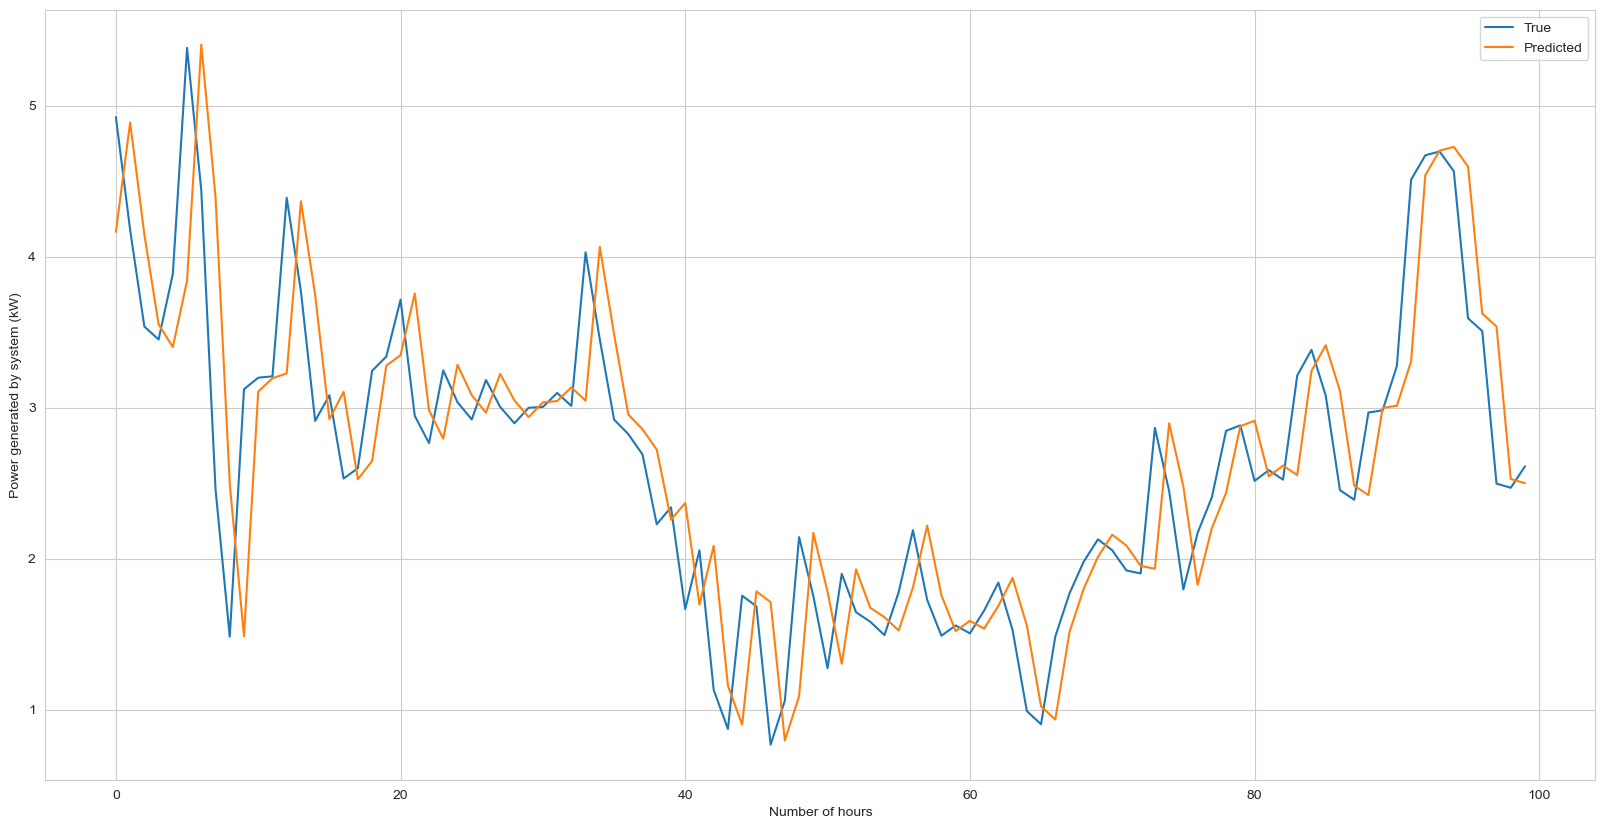

In [60]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(20,10))
pyplot.plot(expectations_plot[0:100], label="True")
pyplot.plot(predictions_plot[0:100], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()

In [61]:
import pickle

In [62]:
Pkl_Filename = "Forcasting_WIndSpeed(E).pkl" 

In [63]:
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lstm_model, file)

In [64]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

## Predicting

In [65]:
predictions 

array([[ 4.16437414],
       [ 4.8883993 ],
       [ 4.14658406],
       ...,
       [ 8.46400724],
       [10.00724493],
       [10.44741521]])

In [66]:
predictions.mean()

8.196032357137314

In [67]:
df["Wind Speed (m/s)"].mean()

7.557349251915261

In [68]:
len(predictions)

9998

In [70]:
type( predictions)

numpy.ndarray

In [72]:
csv_file_path = 'SpeedPredicted.csv'

In [73]:
np.savetxt(csv_file_path, predictions, delimiter=',')